# Case Studies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import pickle
import pynbody
pynbody.config['halo-class-priority'] =  [pynbody.halo.ahf.AHFCatalogue,
                                          pynbody.halo.GrpCatalogue,
                                          pynbody.halo.AmigaGrpCatalogue,
                                          pynbody.halo.legacy.RockstarIntermediateCatalogue,
                                          pynbody.halo.rockstar.RockstarCatalogue,
                                          pynbody.halo.subfind.SubfindCatalogue, pynbody.halo.hop.HOPCatalogue]

%matplotlib inline
mpl.rc('font',**{'family':'serif','monospace':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams.update({'font.size': 9})

In [24]:
def read_file(path, halo_num):
    data = []
    with open(path,'rb') as f:
        while True:
            try: 
                data.append(pickle.load(f))
            except EOFError:
                break
    data = pd.DataFrame(data)
    
    if not halo_num=='all':
        data = data[data.z0haloid == halo_num]

    return data

def cumulative_sfh(halo_num):
    age = 13.800797497330507
    s = pynbody.load('/home/christenc/Data/Sims/h229.cosmo50PLK.3072g/h229.cosmo50PLK.3072gst5HbwK1BH/snapshots/h229.cosmo50PLK.3072gst5HbwK1BH.004096')
    halo = s.halos()[halo_num]
    try:
        sfh, bins = pynbody.plot.stars.sfh(halo, filename=None, massform=False, clear=False, legend=False, subplot=False, trange=False, bins=128)
        plt.clf()
    except ValueError:
        print(f'Cannot create SFH, only {len(halo.s)} star particles')
        raise

    sfhmstar = np.sum(sfh)
    bincenters = 0.5*(bins[1:]+bins[:-1])
    c_sfh = np.empty(shape=sfh.shape)
    for i in range(len(bincenters)):
        c_sfh[i] = np.sum(sfh[:i+1])/sfhmstar 
    return c_sfh, age-bincenters

In [127]:
def CaseStudyPlots(i,simulation_name,showram=True,filename=True):
    path = '/home/akinshol/Data/Timescales/DataFiles/'+str(simulation_name)+'.data'

    data = read_file(path, i)
    # data[:10]

    age = 13.800797497330507
    q_thresh = 0.9
    i_thresh = 1.0
    
    print('Gathering data...')
    time = age - np.array(data['time'], dtype=float)
    gasfrac = np.array(data['gasfrac'], dtype=float)
    gastemp = np.array(data['gtemp'], dtype=float)
    ratio = np.array(data['ratio'], dtype=float)
    dist = np.array(data['h1dist'], dtype=float)
    SNHf = np.array(data['SNHfrac'], dtype=float)
    fHI = np.array(data['fHI'], dtype=float)
    mvir = np.array(data['mass'], dtype=float)
    HIratio = np.array(data['HIratio'], dtype=float)
    mHI = np.array(data['HIratio'],dtype=float)*np.array(data['mstar'],dtype=float)
    mgas = np.array(data['mgas'],dtype=float)
    c_sfh, bc = cumulative_sfh(i)

    shaded_min = -1
    shaded_max = 500*np.max(mgas)

    fig, ax = plt.subplots(1,1,figsize=(4,4), dpi=100)
    ax.plot(time,dist,'g-')
    ax.invert_xaxis()
    ax.set_xlabel('Lookback Time [Gyr]')
    label3 = ax.set_ylabel(r'Distance from Host [$R_{\mathrm{vir}}$]')
    label3.set_color('g')
    ax.semilogy()
    ax.set_xlim(14,0)
    ax.set_ylim(0.1, 25)

    ax1 = ax.twinx()
    ax1.plot(time,ratio,'m-')
    label4 = ax1.set_ylabel(r'$P_{\mathrm{ram}} / P_{\mathrm{rest}}$')
    label4.set_color('m')
    ax1.set_ylim(np.min(ratio[~np.isnan(ratio)])-0.3, np.max(ratio[~np.isnan(ratio)])+1)
    npeaks = 1
    peak_indices = np.argsort(ratio[~np.isnan(ratio)])[-npeaks:]


    ax.fill_between(time, shaded_min, shaded_max, where=(dist < 1), edgecolor='none',alpha=0.2, facecolor='g')

    for index in peak_indices:
        t = time[~np.isnan(ratio)][index]
        ax.plot([t,t],[shaded_min,shaded_max], 'm--', linewidth=1)

    if showram:
        plt.show()

    fig, ax = plt.subplots(1,3,figsize=(18,4),dpi=300)
    for i in [0,1,2]:
        ax[i].fill_between(time, shaded_min, shaded_max, where=(dist < 1), edgecolor='none',alpha=0.2, facecolor='g')

    for i in [0,1,2]:
        for index in peak_indices:
            t = time[~np.isnan(ratio)][index]
            ax[i].plot([t,t],[shaded_min,shaded_max], 'm--', linewidth=1)


    ax[0].plot(bc, c_sfh, 'r-')
    ax[0].invert_xaxis()
    ax[0].set_xlabel('Lookback Time [Gyr]')
    label1 = ax[0].set_ylabel('Cumulative, Normalized SFH')
    label1.set_color('r')
    ax[0].set_ylim(-0.05,1.05)
    ax[0].set_xlim(14,0)

    ax0 = ax[0].twinx()
    ax0.plot(time,HIratio,'b-')
    ax0.set_ylim(-1,10)
    label2 = ax0.set_ylabel(r'$M_{\mathrm{HI}}\ /\ M_{*}$')
    label2.set_color('b')
    t = np.max(bc[c_sfh >= 0.99])

    for i in [0,1,2]:
        ax[i].plot([t,t],[shaded_min,shaded_max], 'r--', linewidth=1)


    ax[1].plot(time,mHI,color='#370ec2',label='HI', linestyle='-')
    ax[1].plot(time,mgas,color='#370ec2',label='All Gas', linestyle='--')
    ax[1].set_xlabel('Lookback Time [Gyr]')
    label = ax[1].set_ylabel(r'Gas Mass [$M_{\odot}$]')
    label.set_color('#370ec2')
    ax[1].legend(frameon=False)
    ax[1].semilogy()
    ax[1].invert_xaxis()
    ax[1].set_xlim(14,0)
    allgas = np.append(mgas,mHI)
    allgas = allgas[~np.isnan(allgas)]
    ax[1].set_ylim(0.5*np.min(allgas),1.4*np.max(allgas))

    ax1 = ax[1].twinx()
    ax1.plot(time,gastemp,'k-')
    ax1.invert_xaxis()
    ax1.set_xlabel('Lookback Time [Gyr]')
    ax1.set_ylabel('Mean Gas Temperature [K]')
    ax1.set_xlim(14,0)
    ax1.set_ylim(0.85*np.min(gastemp[~np.isnan(gastemp)]), 1.05*np.max(gastemp[~np.isnan(gastemp)]))

    # ax[2].set_ylim(0.85*np.min(gastemp[~np.isnan(gastemp)]), 1.4*np.max(gastemp[~np.isnan(gastemp)]))
    # ax[2].plot(time,data['outflow_temp_23'],label='Outflow')
    # ax[2].plot(time,data['inflow_temp_23'],label='Inflow')
    # ax[2].legend(frameon=False, prop={'size':9})
    # ax[2].semilogy()


    netflux = data['outflow_91'] + data['inflow_91']
    # ax[2].plot(time, netflux, color='#ad7617', linestyle='-')
    # ax[2].invert_xaxis()
    # label5 = ax[2].set_ylabel(r'Net Gas Flux [$M_{\mathrm{\odot}}\ \mathrm{yr}^{-1}$]')
    # label5.set_color('#ad7617')
    # ax[2].set_ylim(1.2*np.min(netflux),1.2*np.max(netflux))
    for i in [0,1,2]:
        ax[i].fill_between(time, shaded_min,shaded_max, where=(netflux < 0.), edgecolor='none',alpha=0.2, facecolor='#ad7617')

    ax[2].invert_xaxis()
    ax[2].plot(time,abs(data['outflow_91']), color='r',label='outflow')
    ax[2].plot(time,abs(data['inflow_91']), color='orange', label='inflow')
    ax[2].set_ylabel('Outflow Rate / Inflow Rate')
    ax[2].legend(frameon=False)
    alloutflows = np.append(abs(data['outflow_91']),abs(data['inflow_91']))
    alloutflows = alloutflows[~np.isnan(alloutflows)]
    ax[2].set_ylim(-0.001,1.3*np.max(alloutflows))
    ax[2].set_xlim(14,0)

    ax2 = ax[2].twinx()
    ax2.plot(time,SNHf, c='b')
    label = ax2.set_ylabel('SN Heated Fraction')
    label.set_color('b')


    plt.subplots_adjust(wspace=0.45)
    if filename:
        f = 'case_study_'+str(simulation_name)+'_'+str(i)+'.png'
        plt.savefig('CaseStudyPlots/'+f, dpi=300)
    else:
        plt.savefig('CaseStudyPlots/'+str(filename), dpi=300)
    plt.show()

# Halo 91

Gathering data...


<Figure size 432x288 with 0 Axes>

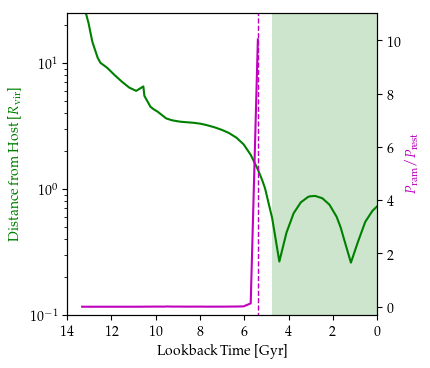

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:96: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


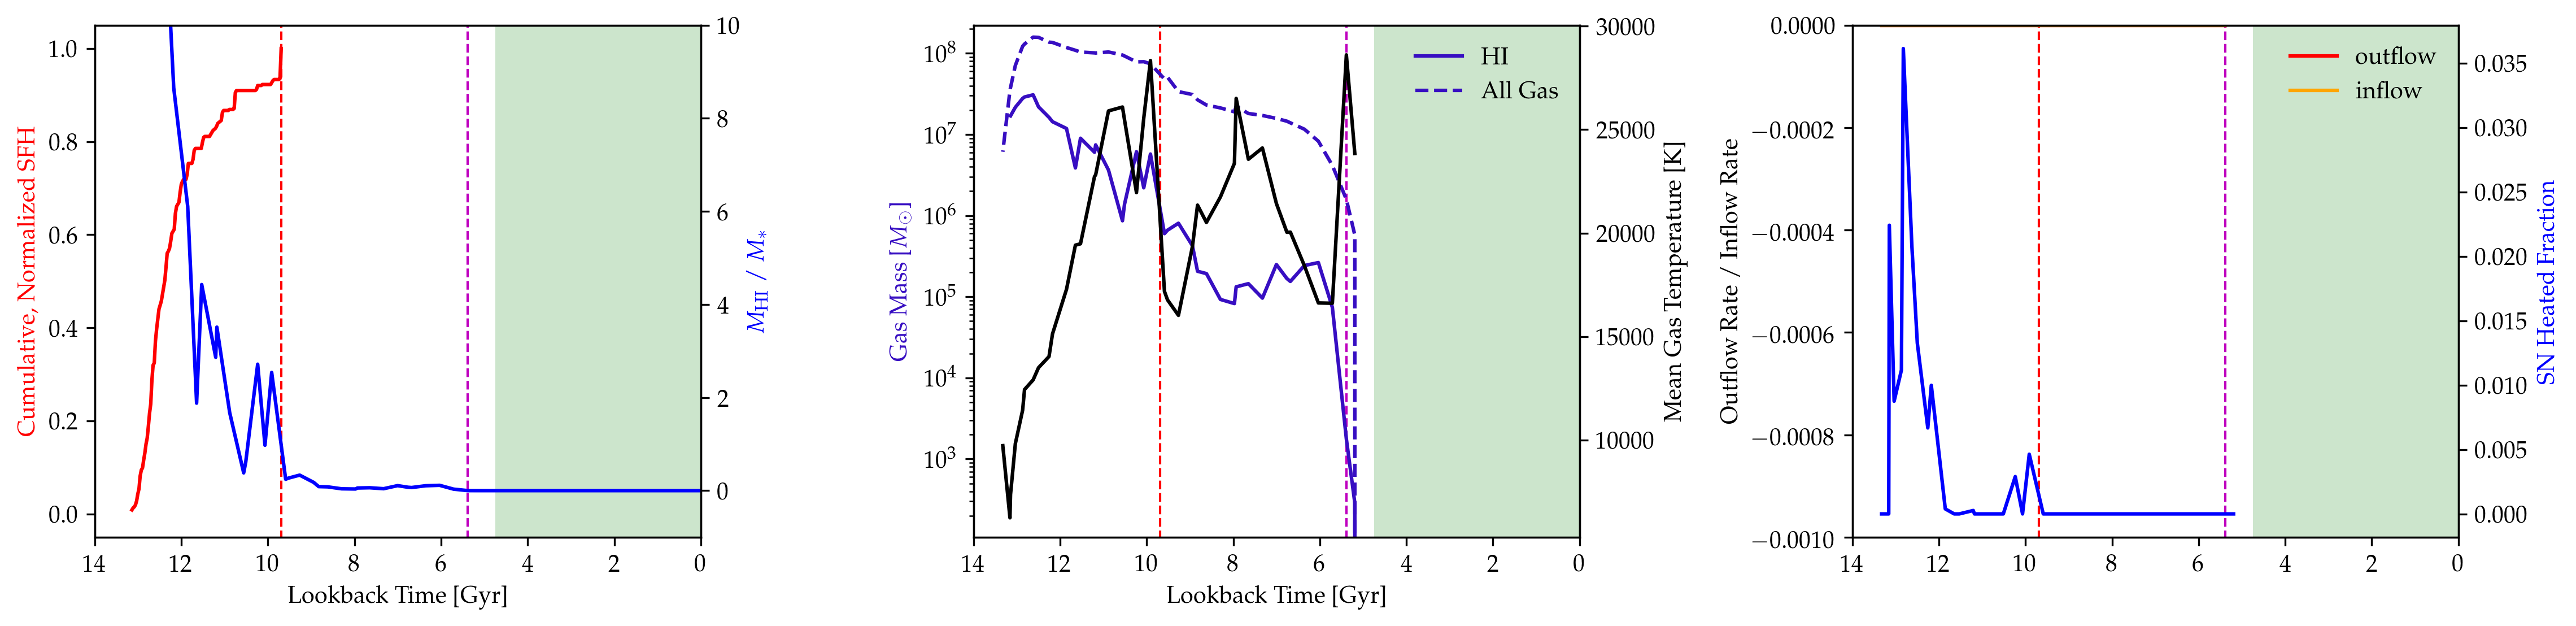

In [128]:
CaseStudyPlots(91,'h229')

Gathering data...


<Figure size 432x288 with 0 Axes>

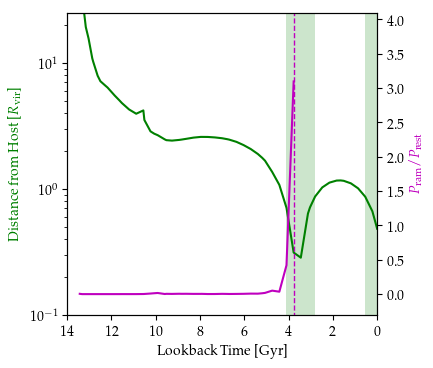

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:96: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


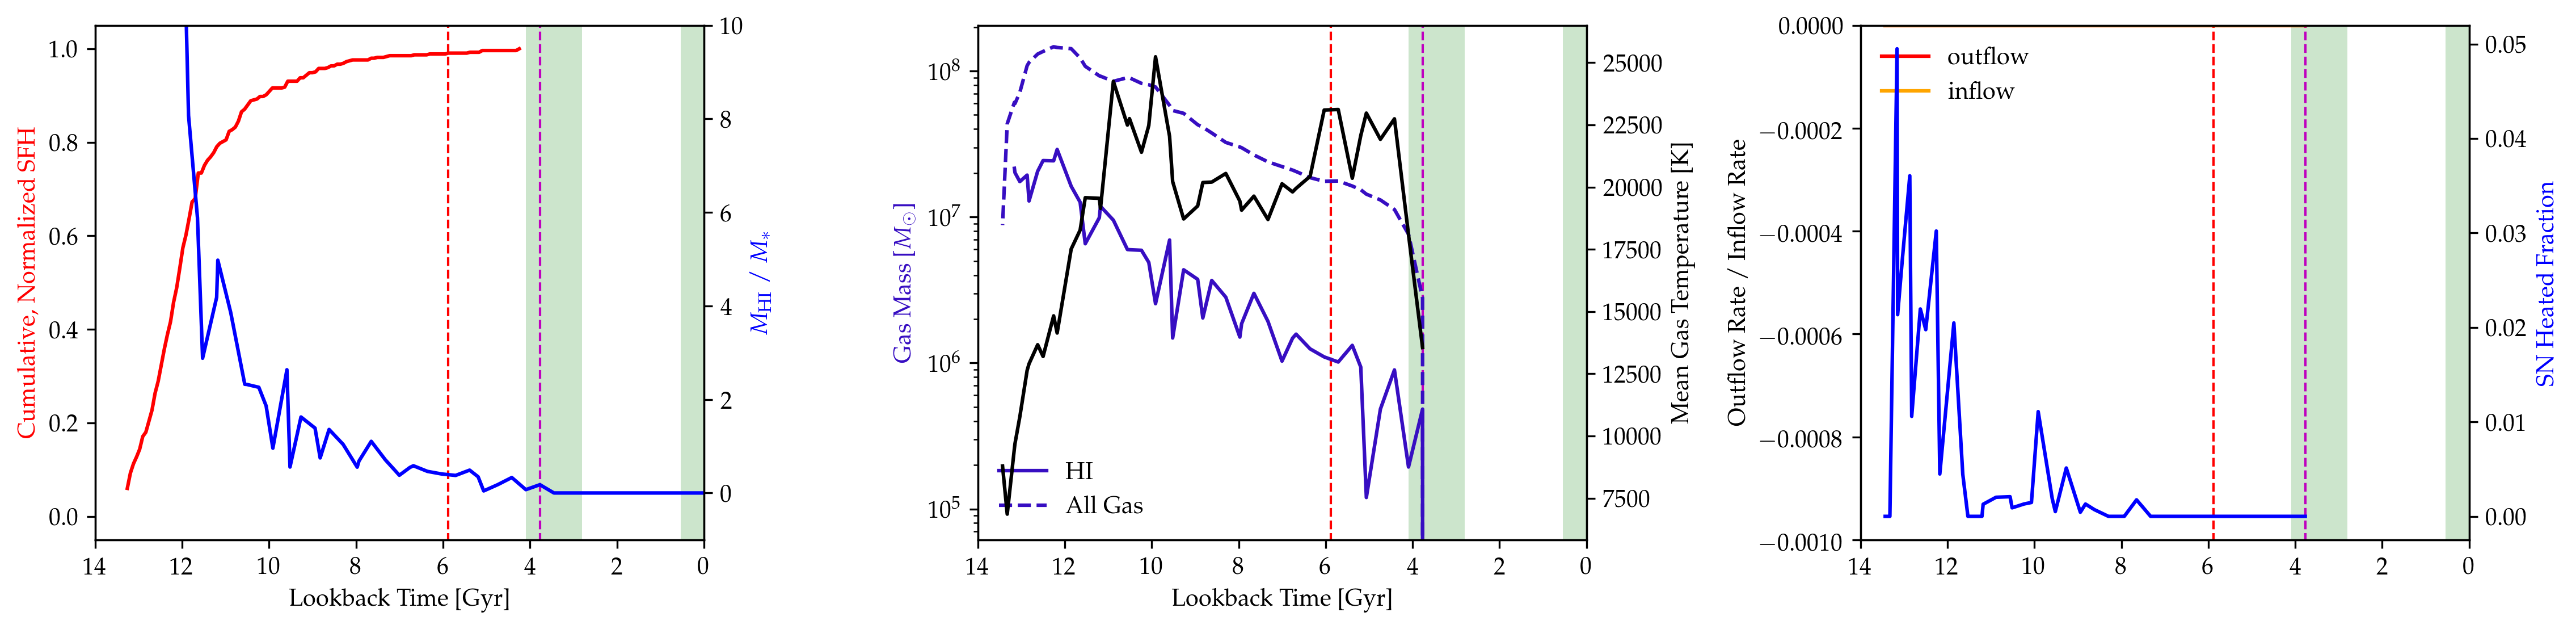

In [129]:
CaseStudyPlots(67,'h229')

Gathering data...


<Figure size 432x288 with 0 Axes>

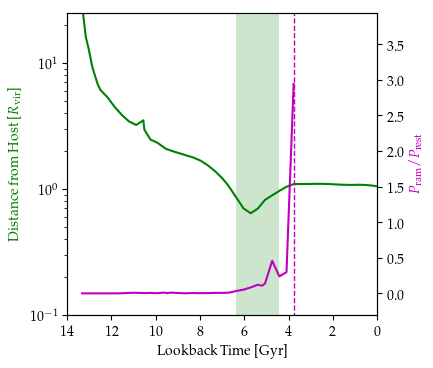

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:96: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


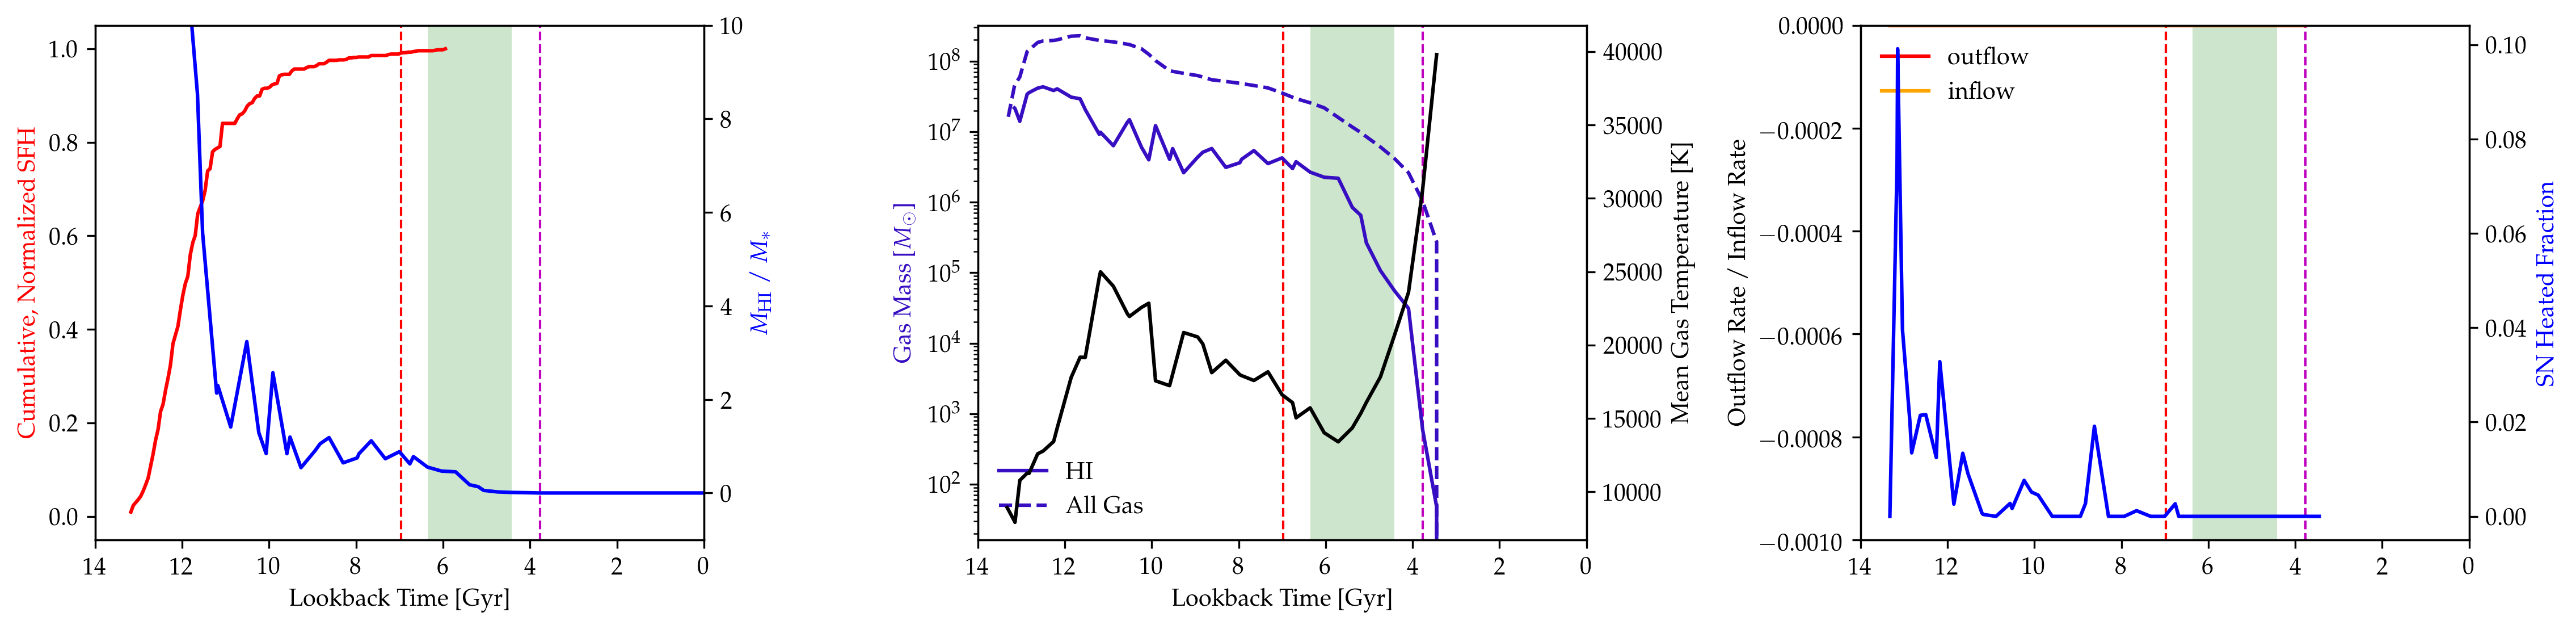

In [148]:
CaseStudyPlots(24,'h229')

Gathering data...


<Figure size 432x288 with 0 Axes>

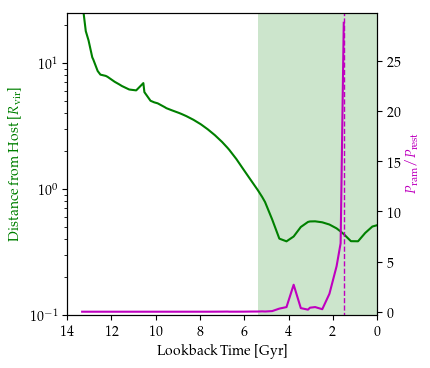

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:96: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


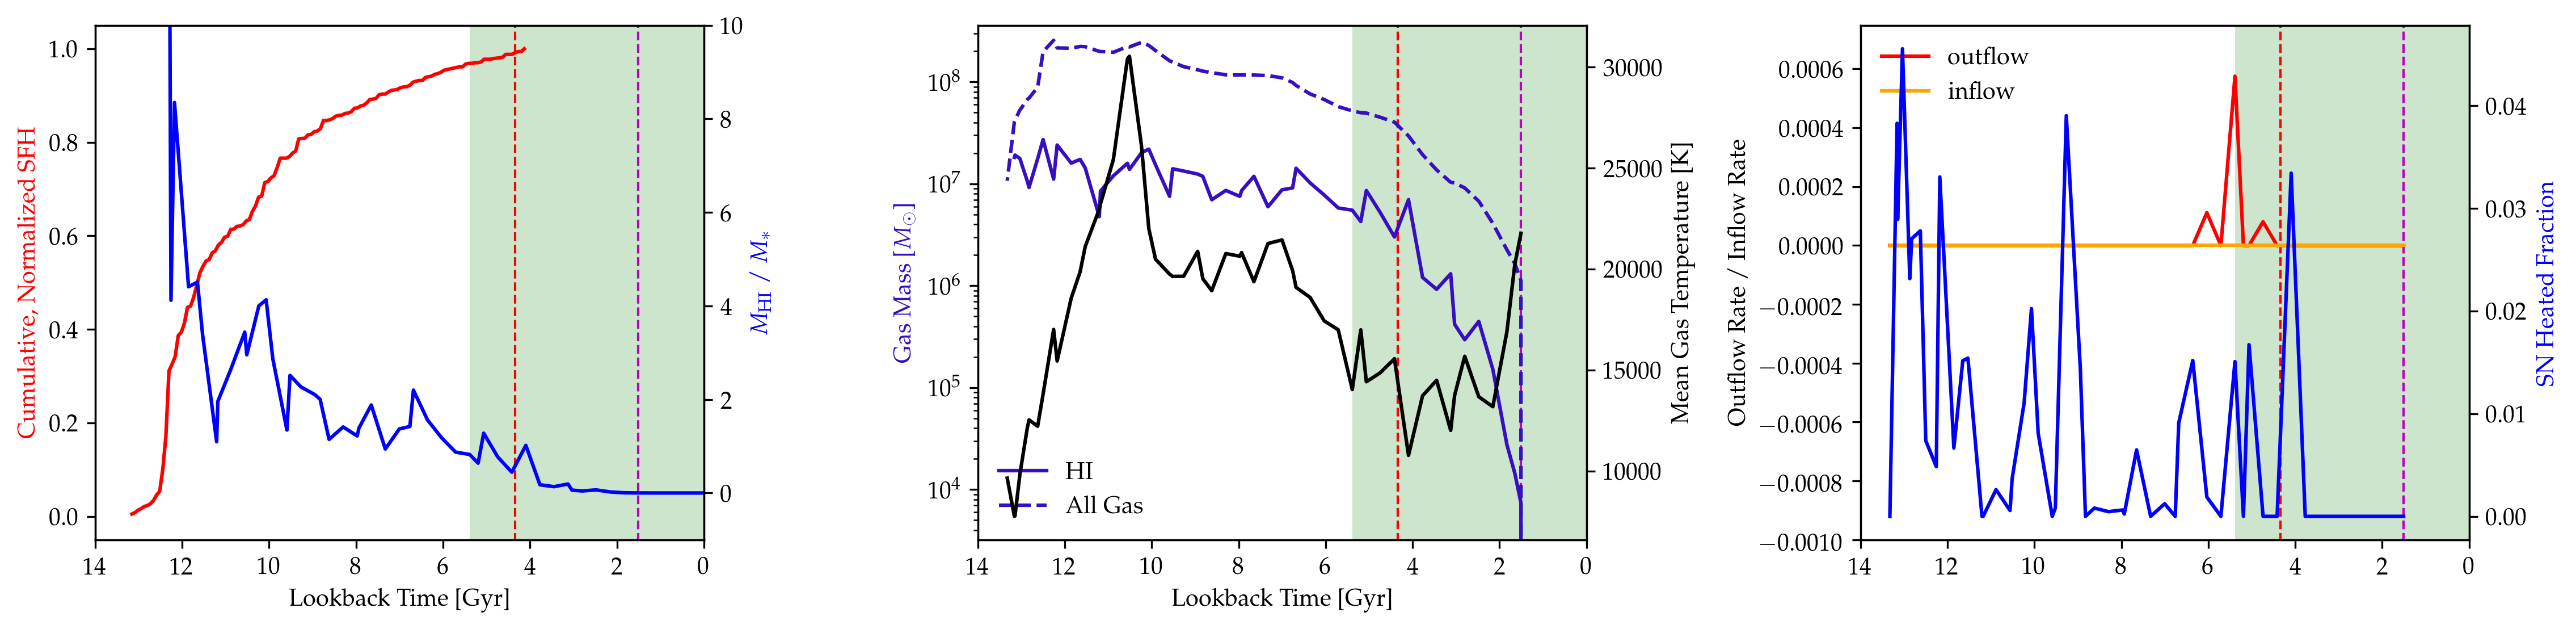

In [150]:
CaseStudyPlots(45,'h229')

Gathering data...


<Figure size 432x288 with 0 Axes>

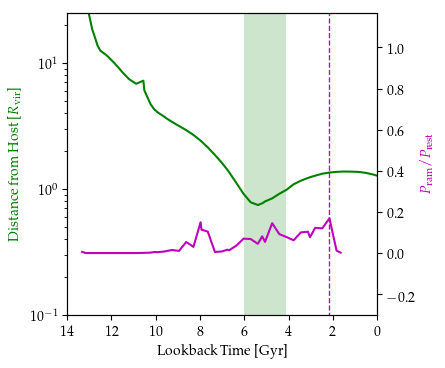

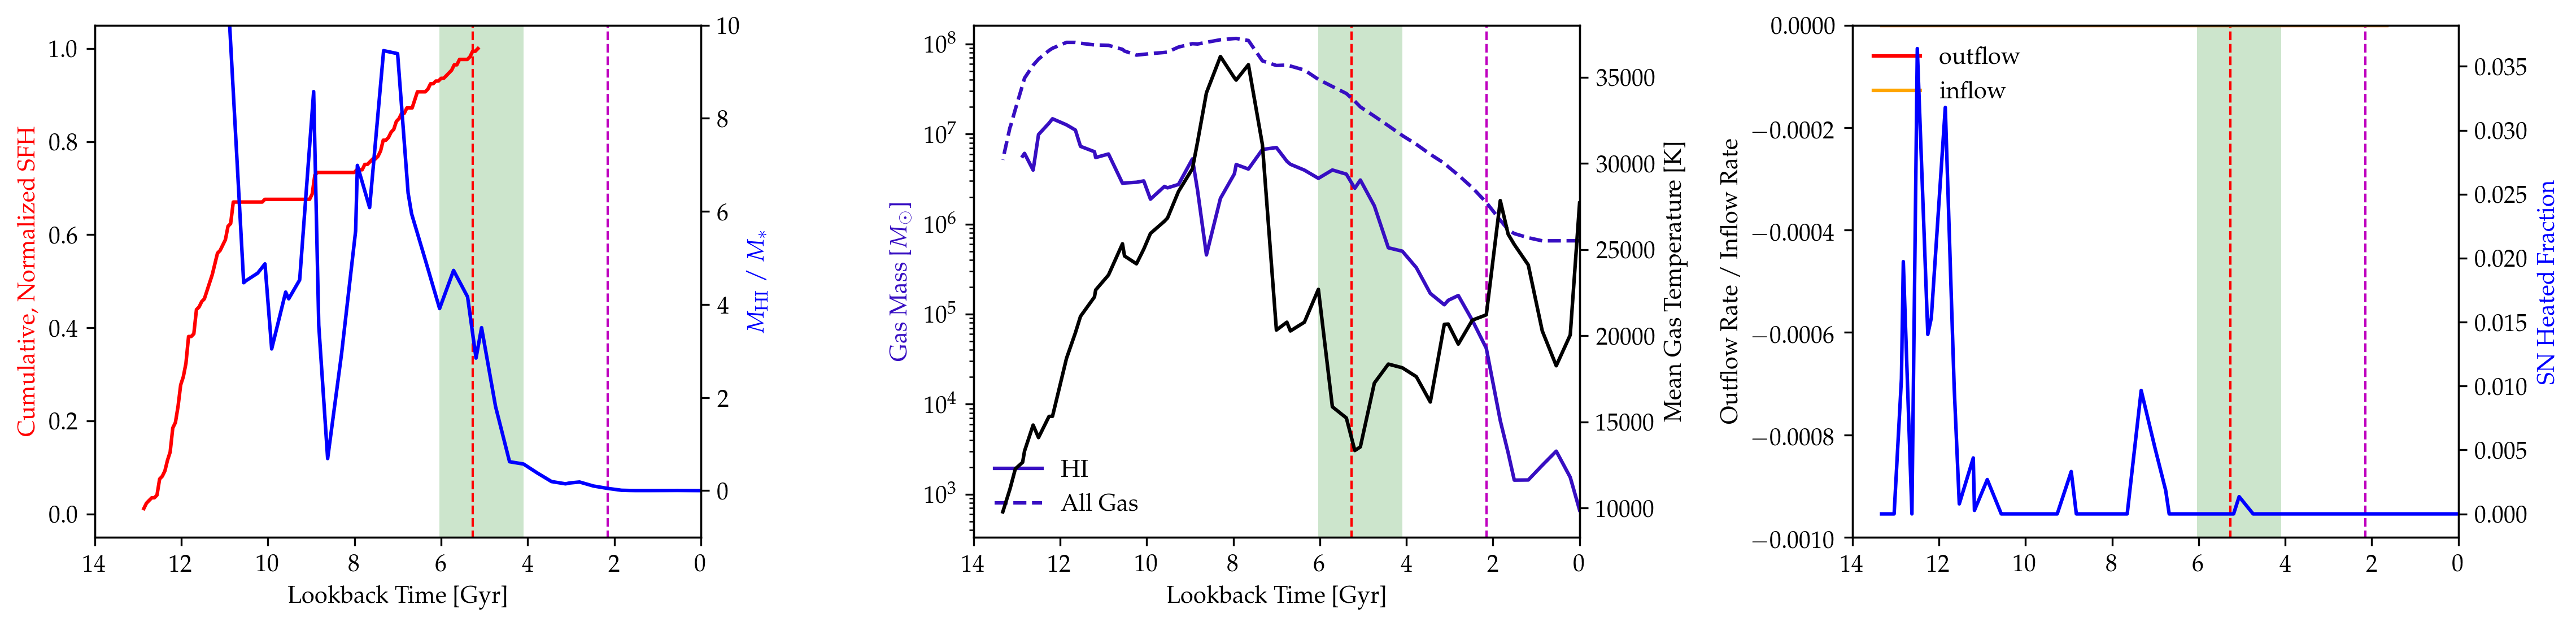

In [151]:
CaseStudyPlots(21,'h229')

In [149]:
data = read_file('/home/akinshol/Data/Timescales/DataFiles/h229.data', 24)
data

HIratio          Pram               Prest   Rvir  \
12                       0.0  1.122022e+07                None  16.62   
49                       0.0  1.077183e+07                None  16.81   
85                       0.0  1.057443e+07                None  17.10   
121                      0.0  1.102551e+07                None  17.39   
155                      0.0  1.239371e+07                None  17.66   
189                      0.0  1.121600e+07                None  17.94   
222                      0.0  1.150261e+07                None  18.06   
255                      0.0  1.228949e+07                None  18.22   
287                      0.0  1.414894e+07                None  18.49   
319                      0.0  1.536006e+07                None  18.78   
351                      0.0  1.973464e+07                None  19.08   
383                      0.0  1.542041e+07                None  19.31   
415                      0.0  1.345000e+07                None  19.42   
447   1.0007239763071875e-05  1.049708e+07                None  19.77   
479   0.00012557985082622958  9.384120e+06  3190389.0136192073  20.17   
511     0.006492594788450969  9.633968e+06  32259436.455608256  20.67   
543      0.01157274162714921  1.505626e+07  63153540.919978335  21.31   
575     0.022315692580097142  5.432247e+07  118734730.12202474  22.02   
607      0.05517854239852622  3.000256e+07  215731274.13520688  22.84   
638       0.1353523394200439  4.548301e+07  423322125.18703943  23.18   
669      0.17535764881167595  7.424037e+07   611855021.7991412  15.77   
700      0.45254506239600906  9.158153e+07    1096150746.17086  24.54   
731      0.46836268363971745  8.686344e+07   1669206548.325463  25.19   
762       0.5533649798334263  3.319747e+07   977771925.5731691  22.99   
793       0.7786275566189841  1.407295e+07  1298498270.1313968  13.76   
824       0.6229485970346836  1.317923e+07  1468162376.1395183  16.83   
855       0.8826834881423438  7.546694e+06  1141261583.3038578  26.21   
886       0.7327776272495614  5.363730e+06    765739958.352213  26.52   
917        1.116553810467191  3.678779e+06  1255486084.0297198  26.85   
948         0.83943669040453  3.271628e+06   785541141.1233746  27.13   
979       0.7503614075784044  3.268124e+06  1351529083.6383653  27.16   
1010      0.6446830099066341  3.179567e+06   706907633.6670482  27.48   
1041      1.1844770932888458  3.081606e+06   2633672178.944902  27.87   
1072      1.0540775658008477  3.288700e+06  1296638363.2978203  28.10   
1103      0.9031544389055477  3.463838e+06   845402741.7612816  28.21   
1134      0.5412884836994392  3.903997e+06  387870449.32158947  28.46   
1165      1.1961716531702287  5.259543e+06  1445011721.4275832  28.56   
1196      0.8406573153274004  9.436044e+06   836663711.5766568  28.56   
1227       2.572236038397504  4.963670e+06   1806026352.922731  28.53   
1258      0.8432936196783608  4.068684e+06   1212378259.690924  28.57   
1289      1.2897144163900522  3.453161e+06   616958193.4939554  28.60   
1320      3.2370965445857607  2.842515e+06   783520071.0024523  28.60   
1351       3.008154424245776  2.794157e+06   666016135.0902542  28.61   
1382      1.4109035311449287  2.328601e+06  279075383.35806745  28.44   
1413      2.2986677566009104  2.194152e+06  310118926.38056934  28.29   
1444      2.1371286425219194  2.174307e+06  334568209.64278096  28.28   
1475       5.564250799023499  1.831701e+06  1364674351.8922963  28.40   
1505       8.530633133451934  1.240185e+06   2195781167.460078  28.45   
1535      10.834226752595633  6.816415e+05   2595385261.514505  27.86   
1565      18.744952269253968  1.093801e+05   5396410005.978741  25.05   
1595       21.20362440885595  9.077674e+04   6028414100.690493  24.25   
1625      36.384867290075846  4.210003e+04   5148838022.920703  23.69   
1655       46.46116949133484  2.222528e+03   4152569783.786525  23.51   
1685       94.11028155283934  2.674044e+03   784561597.5274016  22.20   
1713  

In [155]:
path = '/home/akinshol/Data/Timescales/DataFiles/h229.data'
data = read_file(path, 67)

c_sfh, bc = cumulative_sfh(67)

tquench = np.max(bc[c_sfh > 0.99])
print(tquench)

5.8784639022052065


<Figure size 432x288 with 0 Axes>

In [156]:
print(data.keys())

Index(['HIratio', 'Pram', 'Prest', 'Rvir', 'SNHfrac', 'fHI', 'gasfrac',
       'gtemp', 'h1dist', 'haloid', 'inflow_23', 'inflow_91', 'inflow_temp_23',
       'inflow_temp_91', 'mass', 'mgas', 'mstar', 'outflow_23', 'outflow_91',
       'outflow_temp_23', 'outflow_temp_91', 'ratio', 'time', 'z0haloid'],
      dtype='object')


In [ ]:
time = age - np.array(data.time,dtype=float)
SFR = np.array(data.sfr)

In [38]:
s = pynbody.load('/home/christenc/Data/Sims/h229.cosmo50PLK.3072g/h229.cosmo50PLK.3072gst5HbwK1BH/snapshots/h229.cosmo50PLK.3072gst5HbwK1BH.004096')
s.physical_units()
h = s.halos()
np.min(h[18].star['age']).in_units('Gyr')


SimArray(2.15577355, 'Gyr')

In [140]:
snapshots = ['h229.cosmo50PLK.3072gst5HbwK1BH.004096', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.004032', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.003936', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.003840', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.003744', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.003648', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.003606', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.003552', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.003456', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.003360', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.003264', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.003195', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.003168', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.003072',
             'h229.cosmo50PLK.3072gst5HbwK1BH.002976', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.002880', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.002784', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.002688', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.002592', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.002554', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.002496', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.002400', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.002304',
             'h229.cosmo50PLK.3072gst5HbwK1BH.002208', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.002112', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.002088', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.002016', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.001920', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.001824',
             'h229.cosmo50PLK.3072gst5HbwK1BH.001740',
             'h229.cosmo50PLK.3072gst5HbwK1BH.001728',
             'h229.cosmo50PLK.3072gst5HbwK1BH.001632', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.001536', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.001475', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.001440', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.001344', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.001269', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.001248',
             'h229.cosmo50PLK.3072gst5HbwK1BH.001152', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.001106', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.001056', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.000974', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.000960',
             'h229.cosmo50PLK.3072gst5HbwK1BH.000864', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.000776', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.000768', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.000672', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.000637', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.000576', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.000480', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.000456', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.000384', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.000347', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.000288', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.000275', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.000225', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.000192', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.000188', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.000139', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.000107', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.000096', 
             'h229.cosmo50PLK.3072gst5HbwK1BH.000071']

Snapshot h229.cosmo50PLK.3072gst5HbwK1BH.000776
Centering...
Generating Image..., width 200 kpc


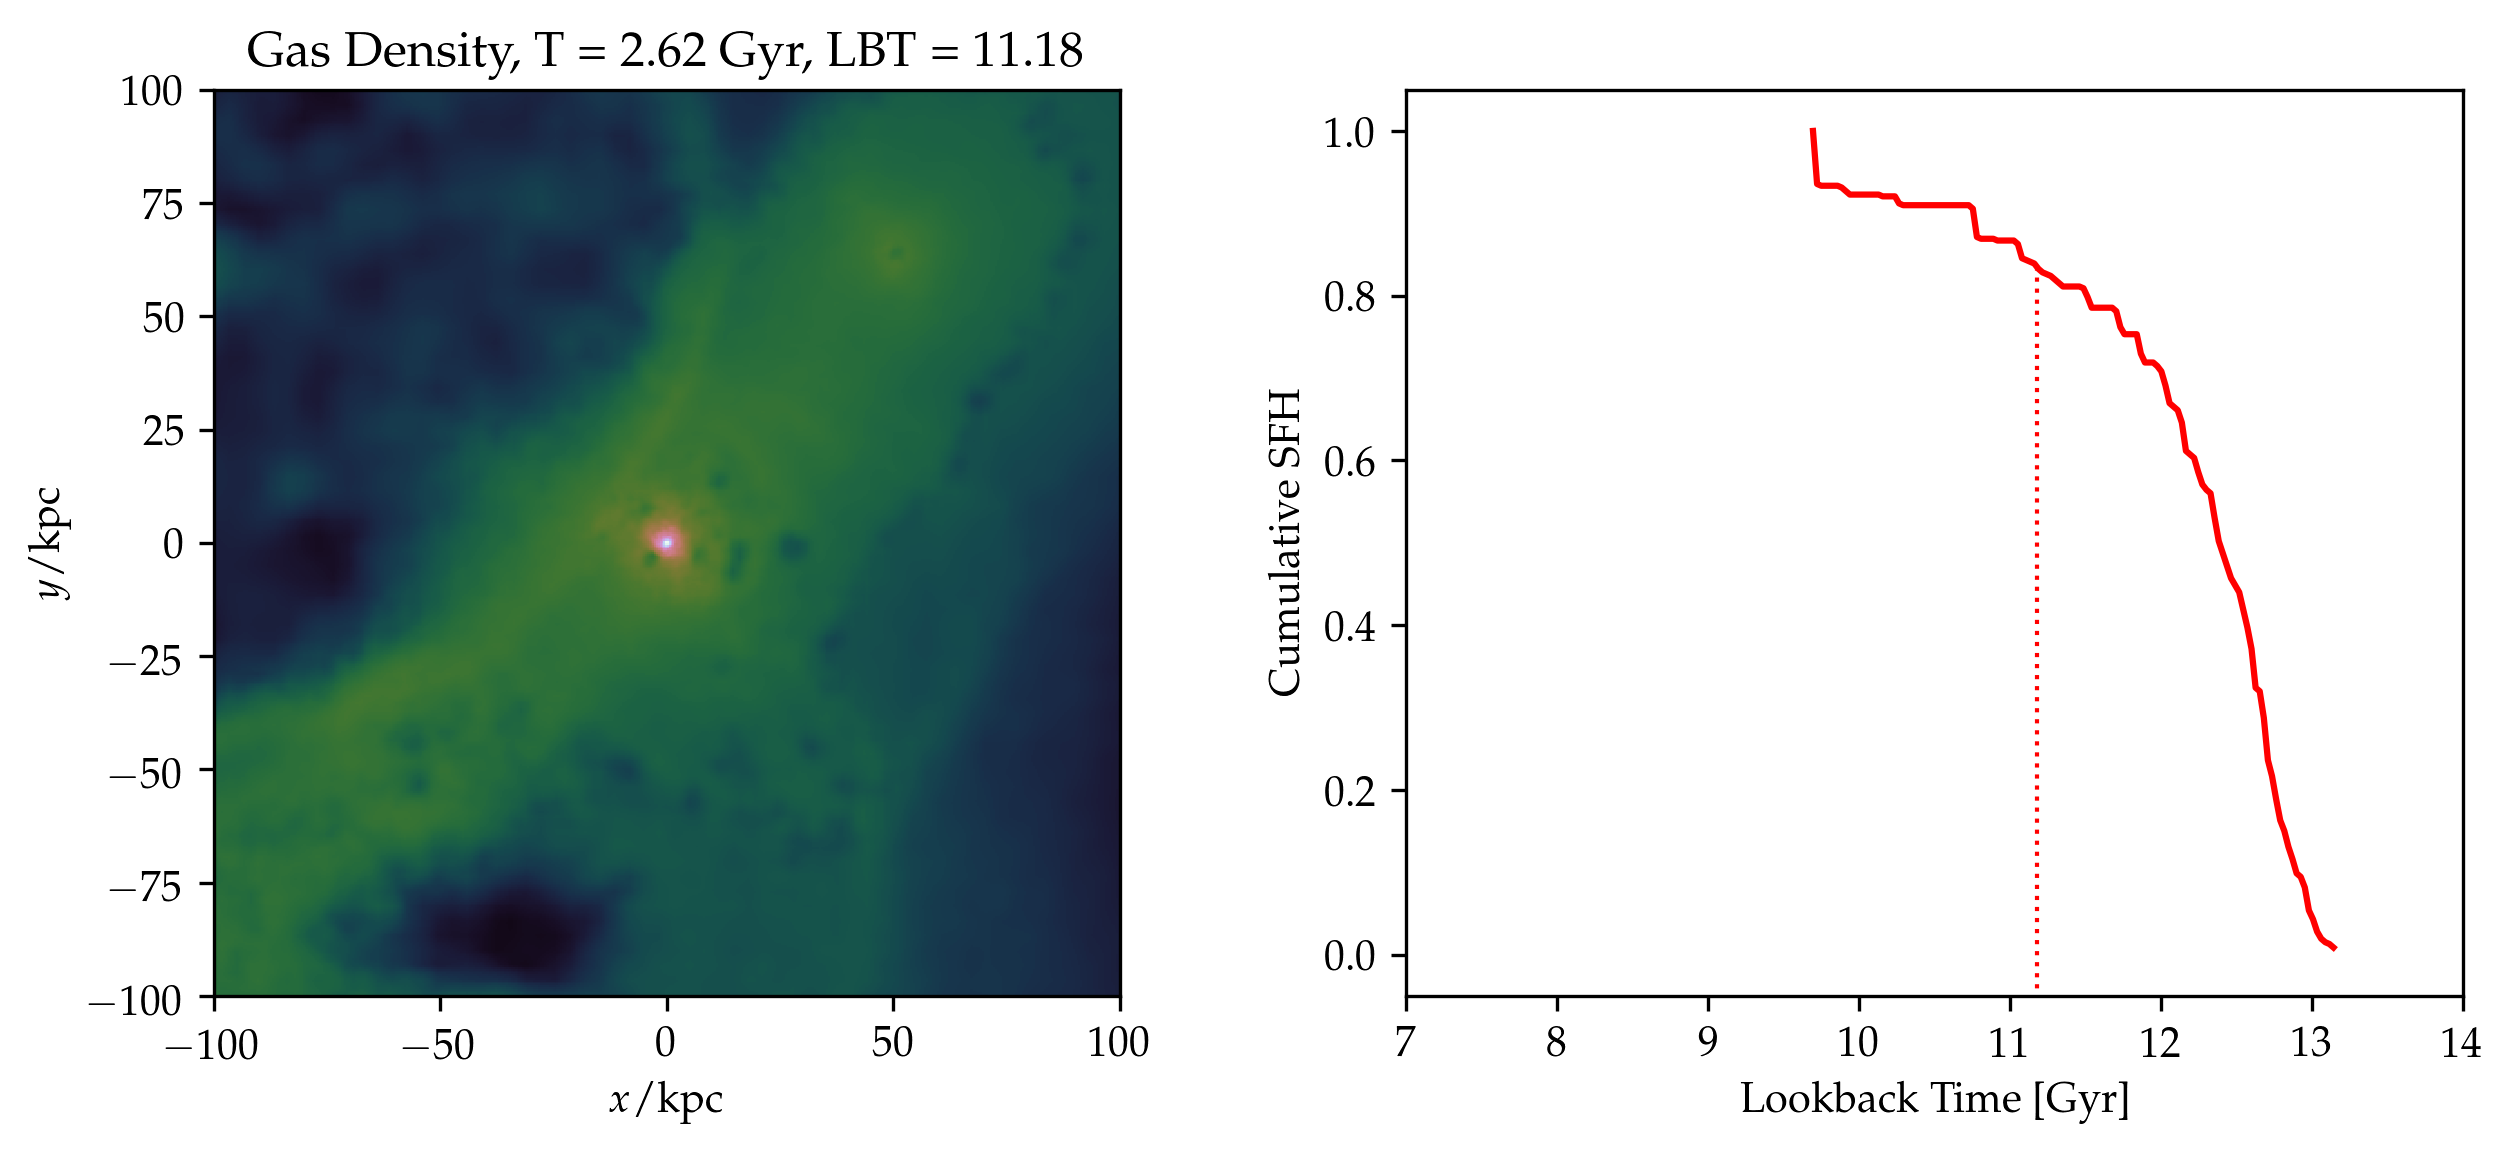

Snapshot h229.cosmo50PLK.3072gst5HbwK1BH.000864
Centering...
Generating Image..., width 200 kpc


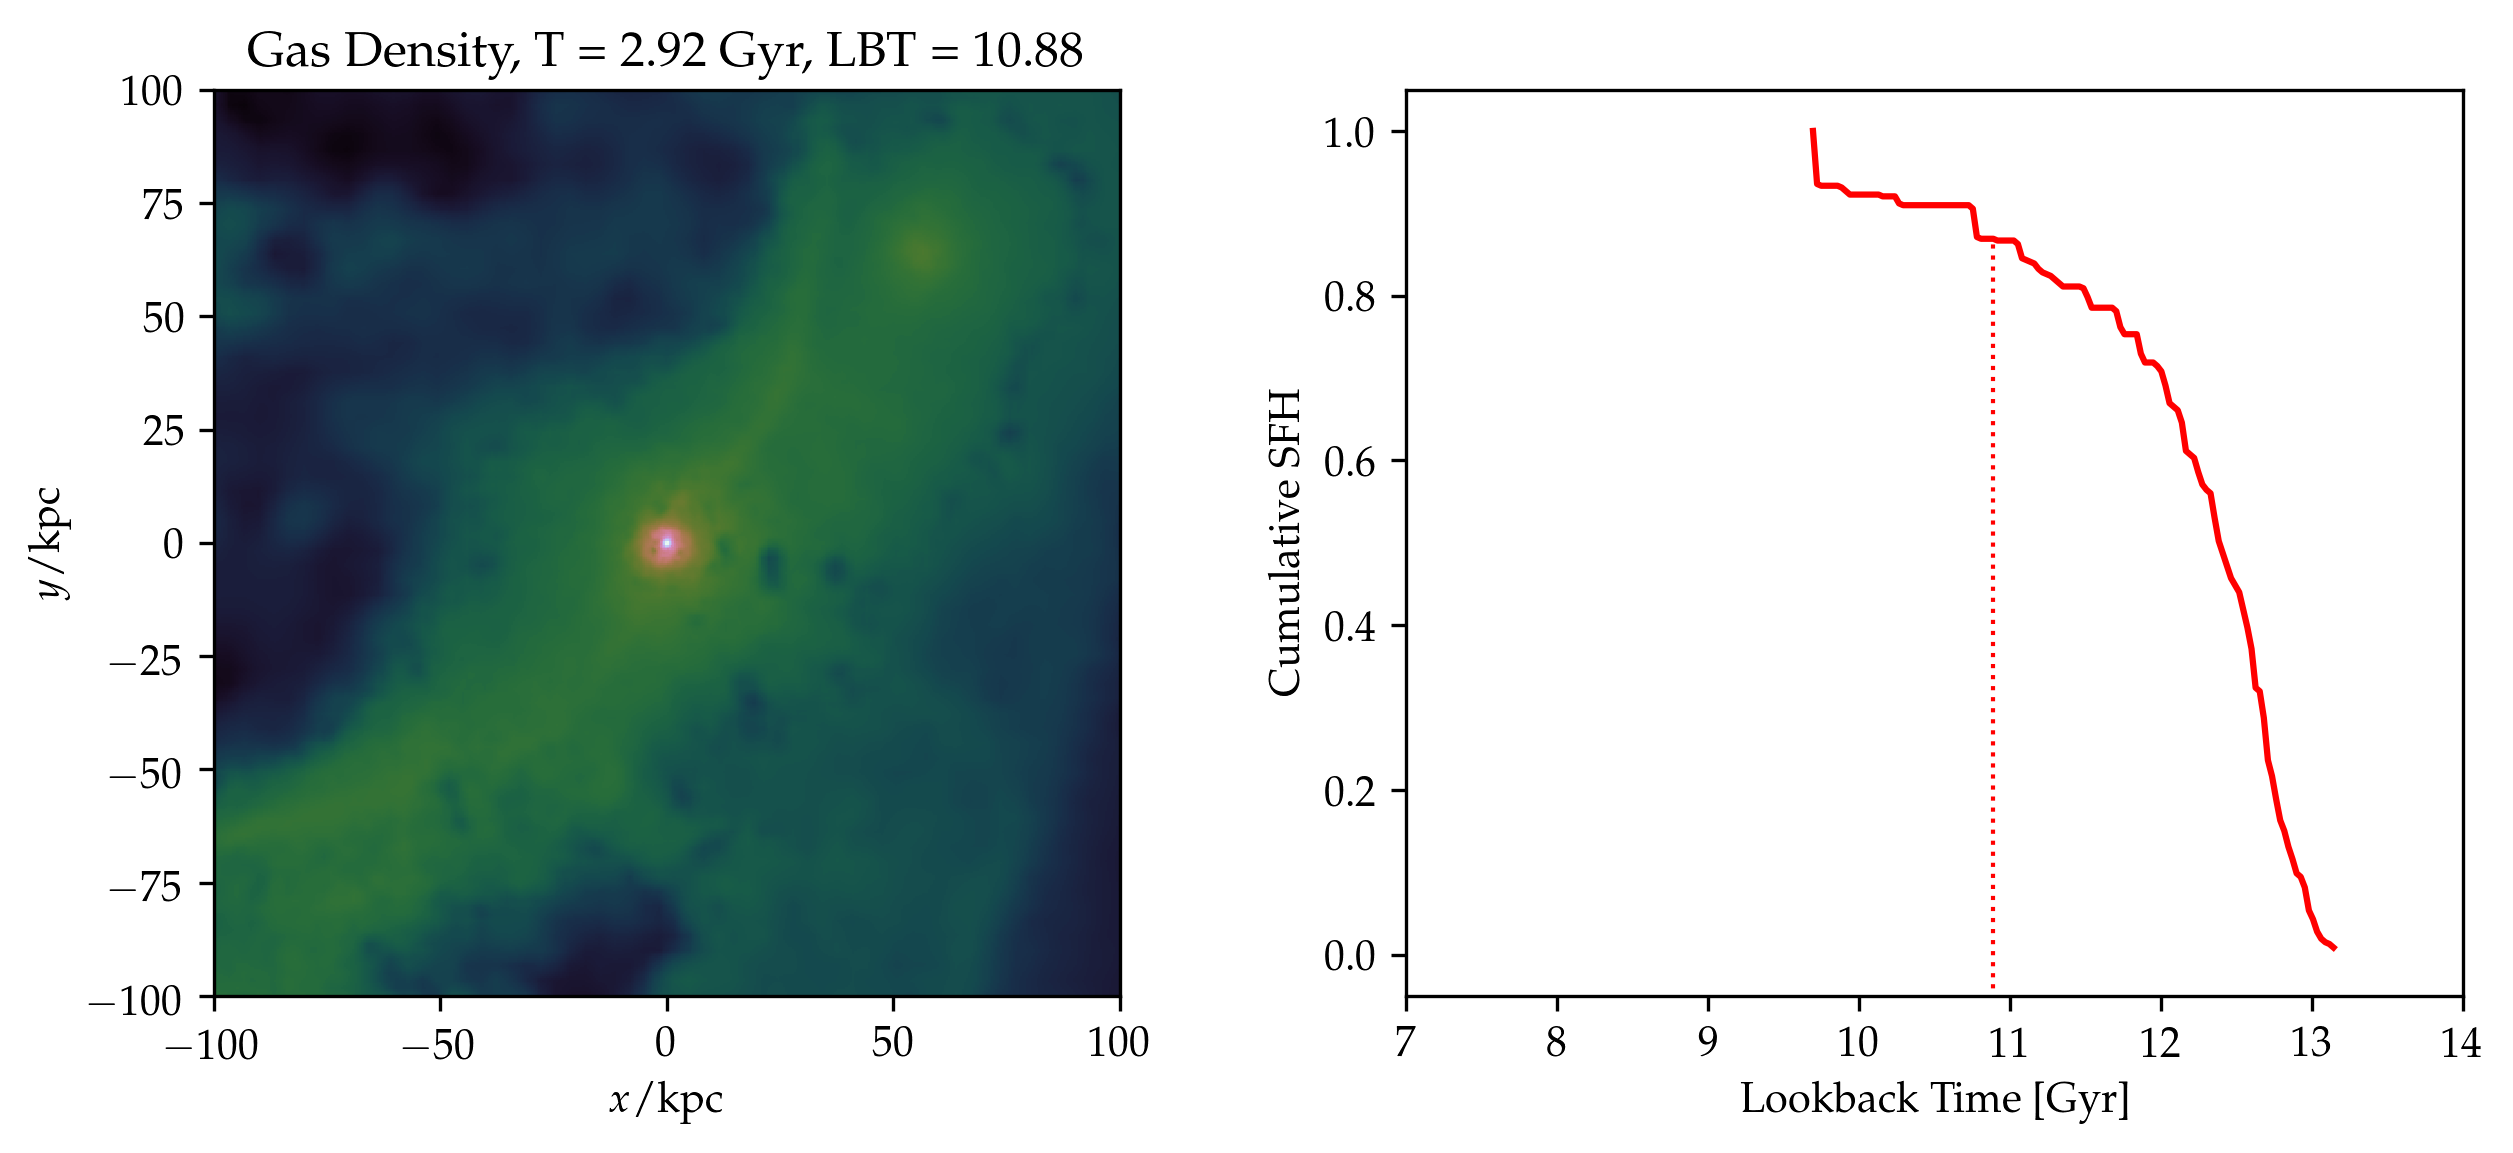

Snapshot h229.cosmo50PLK.3072gst5HbwK1BH.000960
Centering...
Generating Image..., width 200 kpc


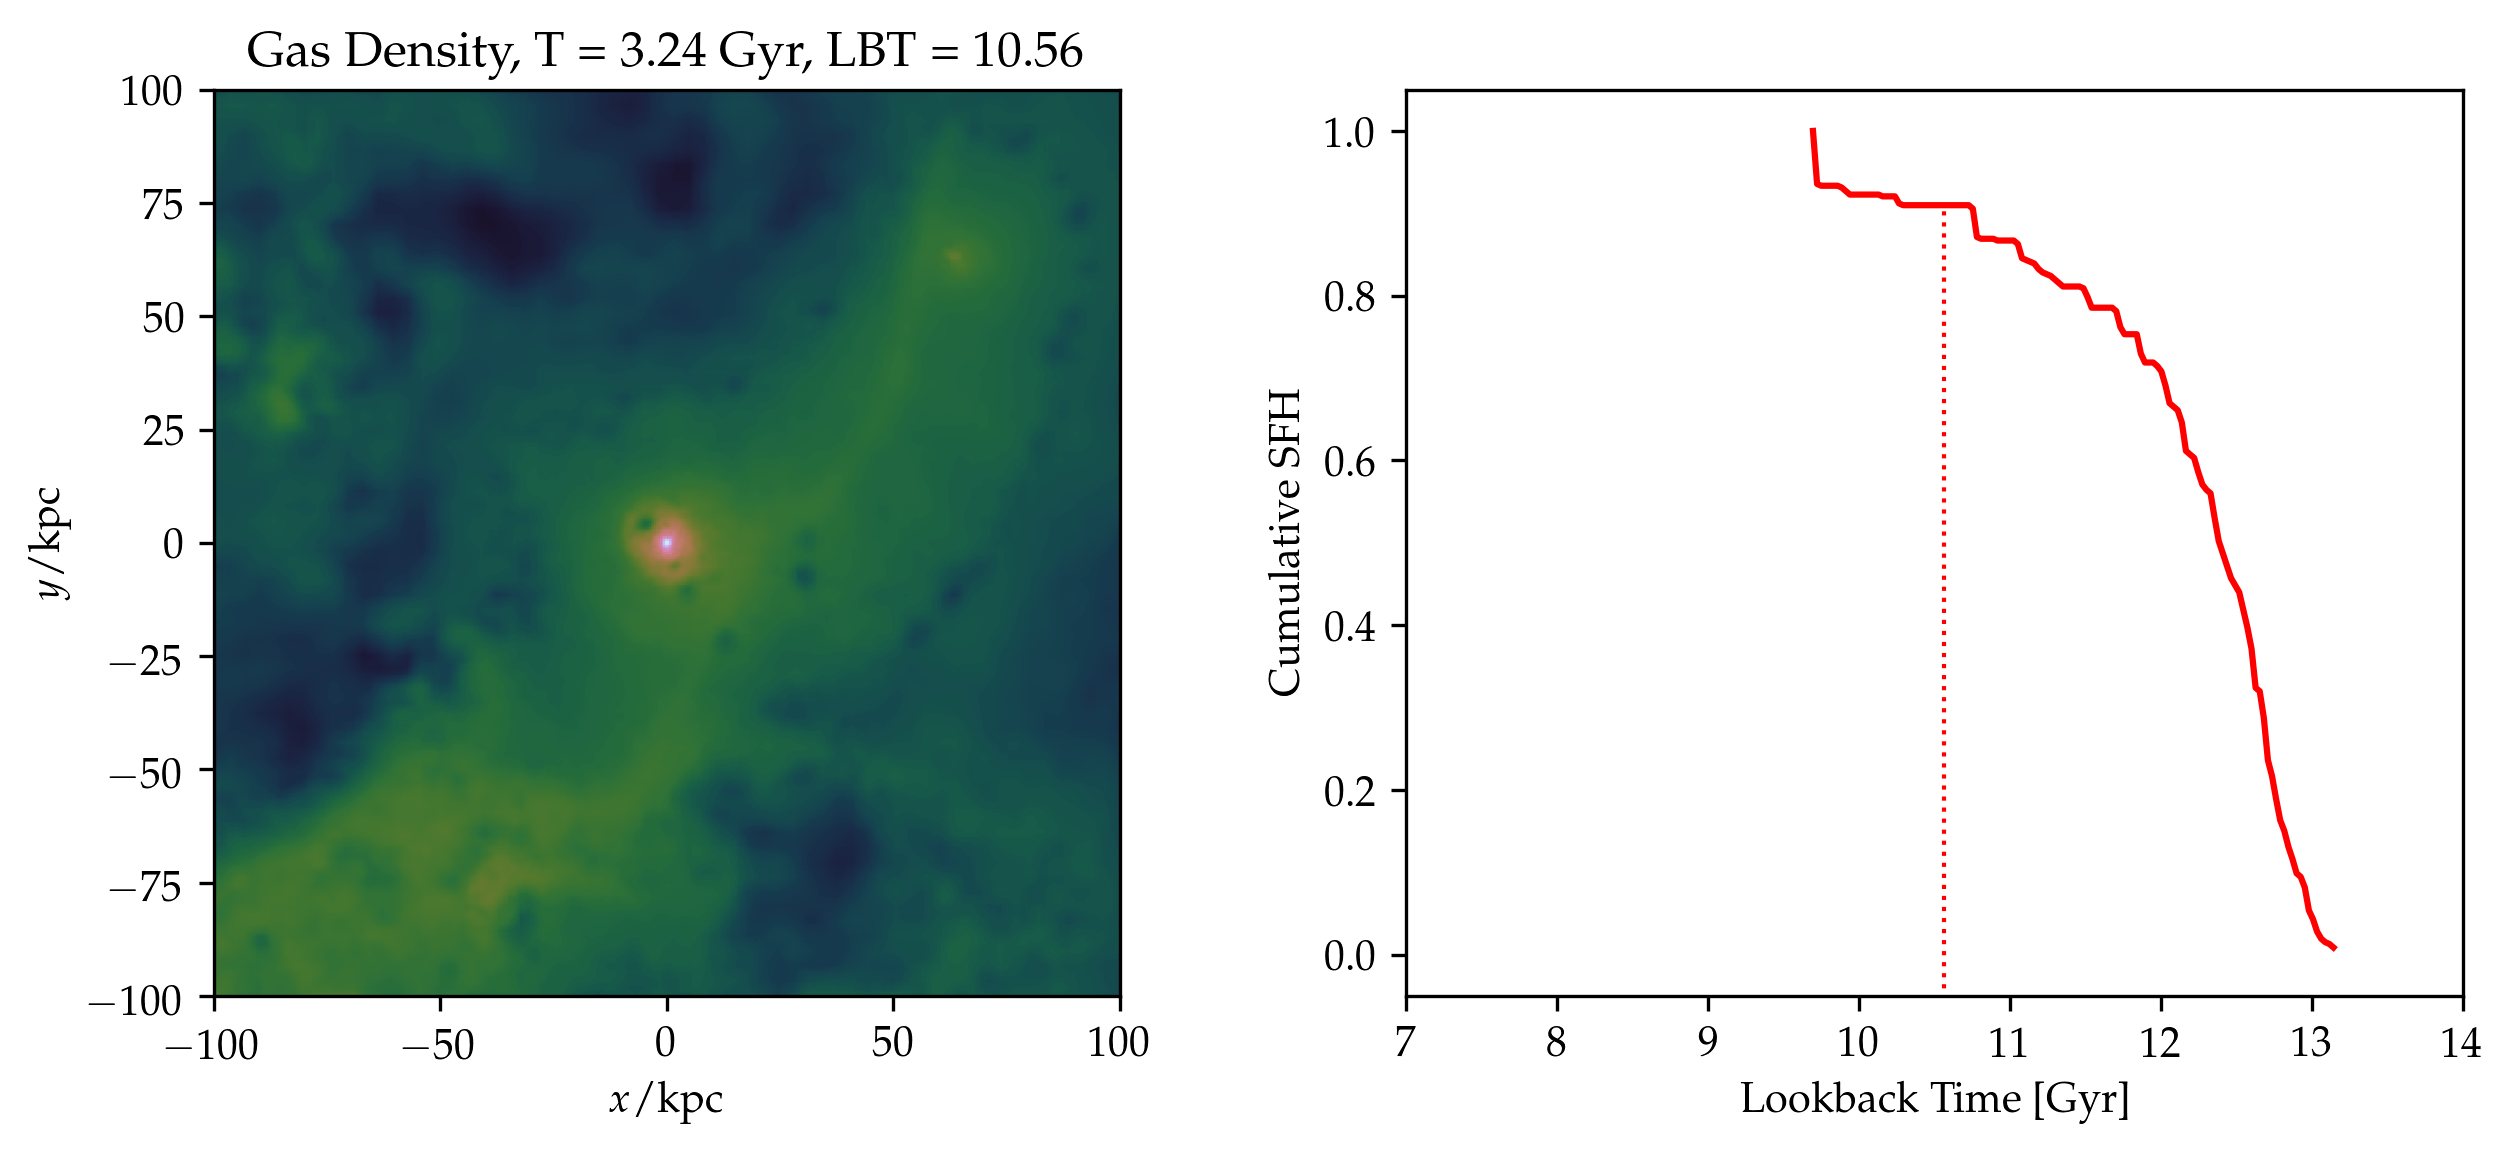

Snapshot h229.cosmo50PLK.3072gst5HbwK1BH.000974
Centering...
Generating Image..., width 200 kpc


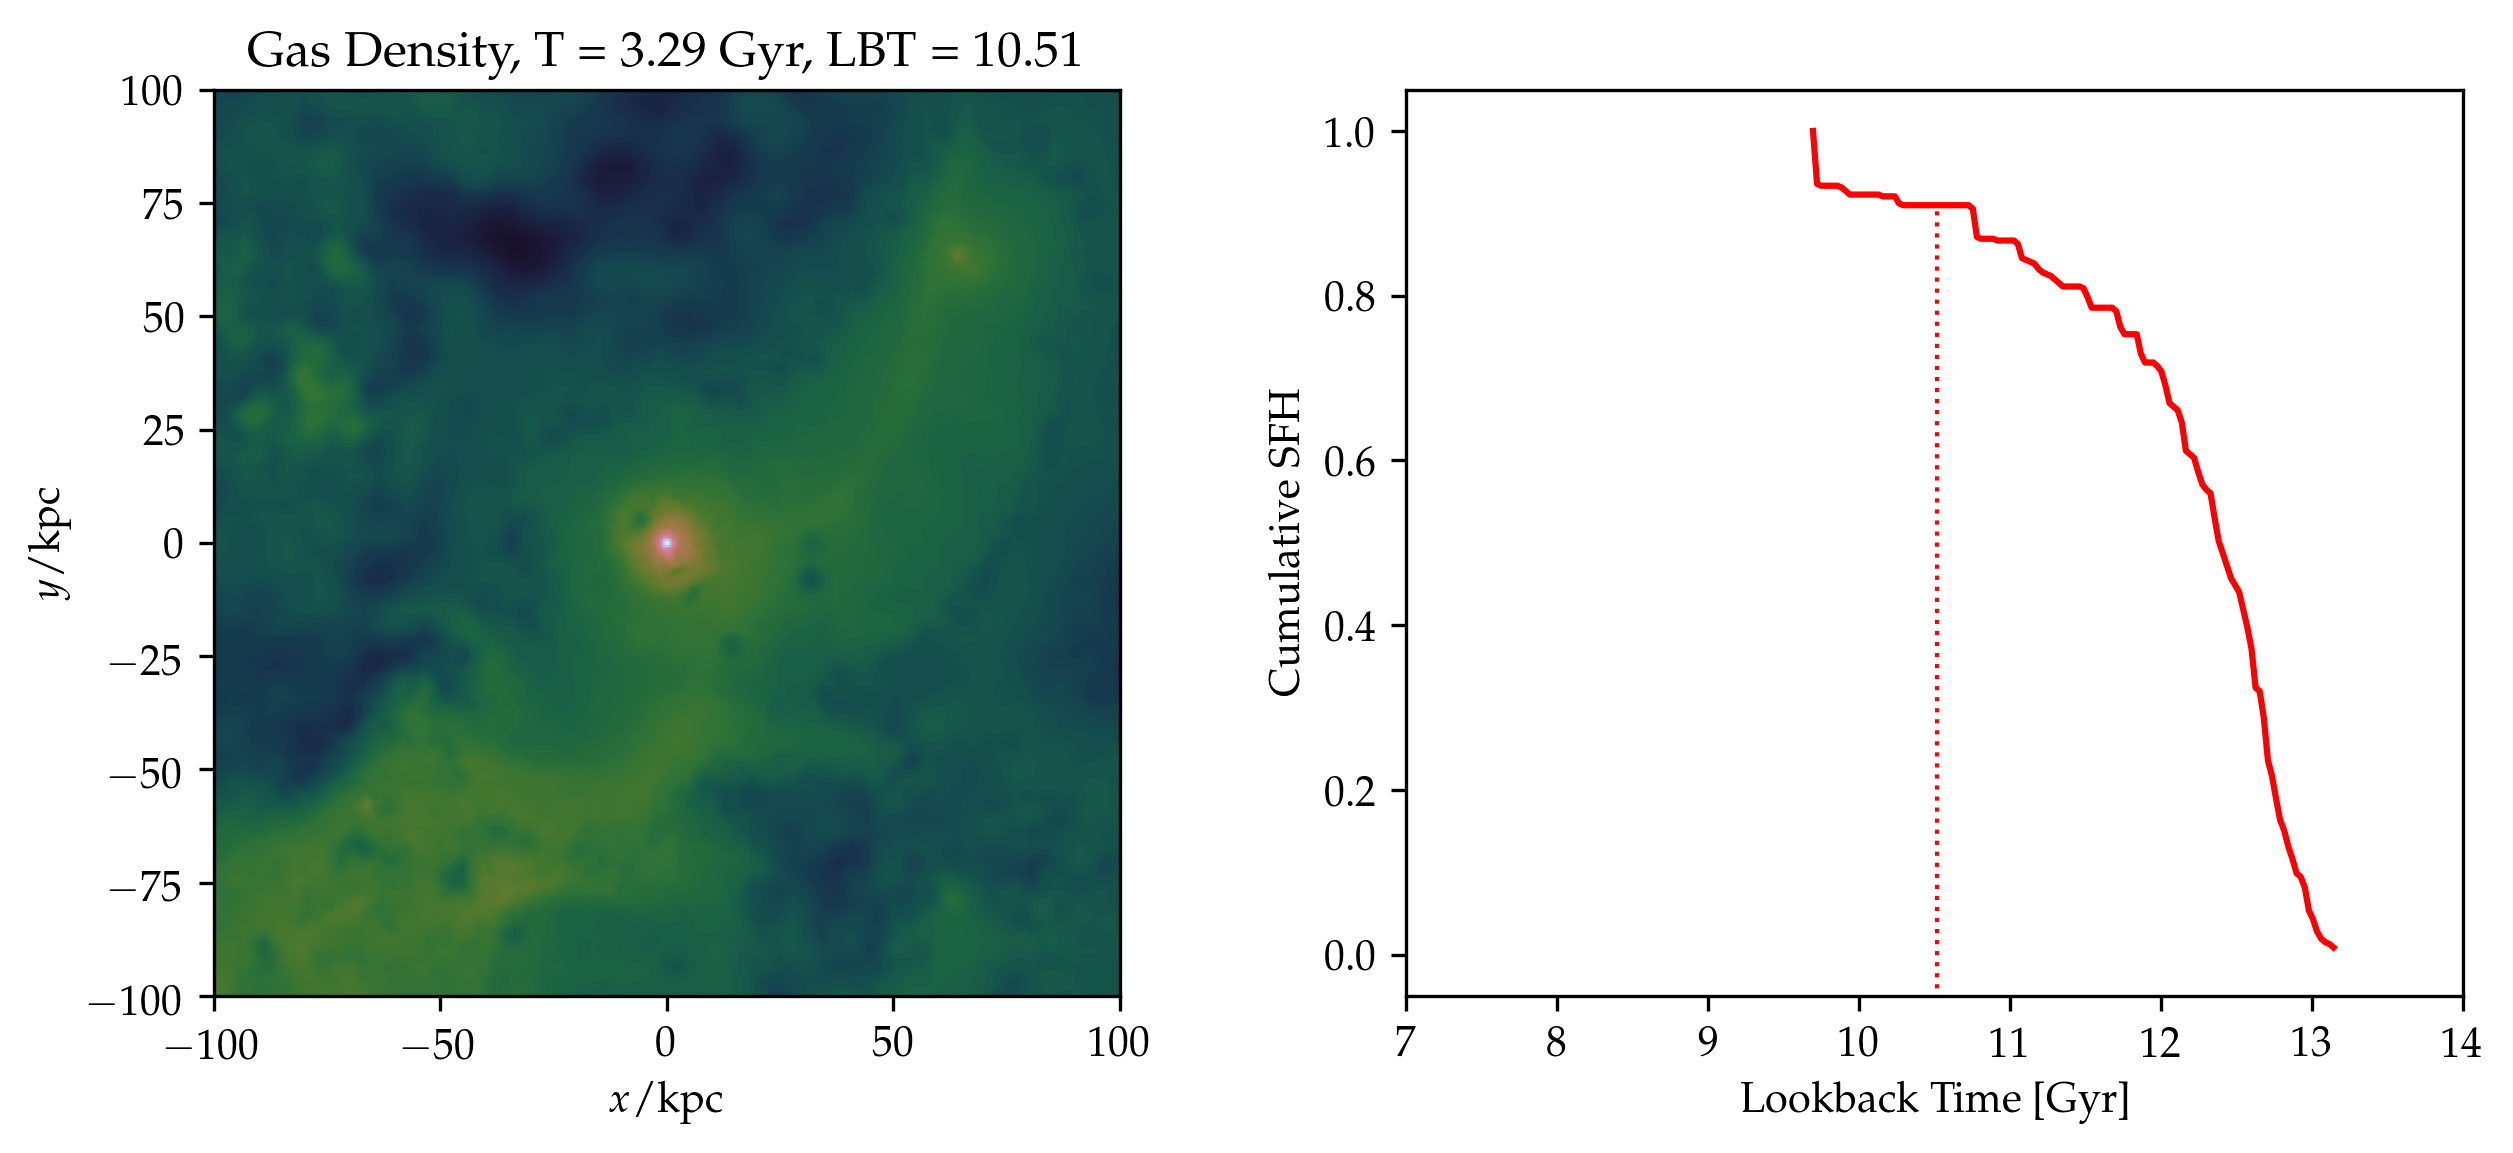

Snapshot h229.cosmo50PLK.3072gst5HbwK1BH.001056
Centering...
Generating Image..., width 200 kpc


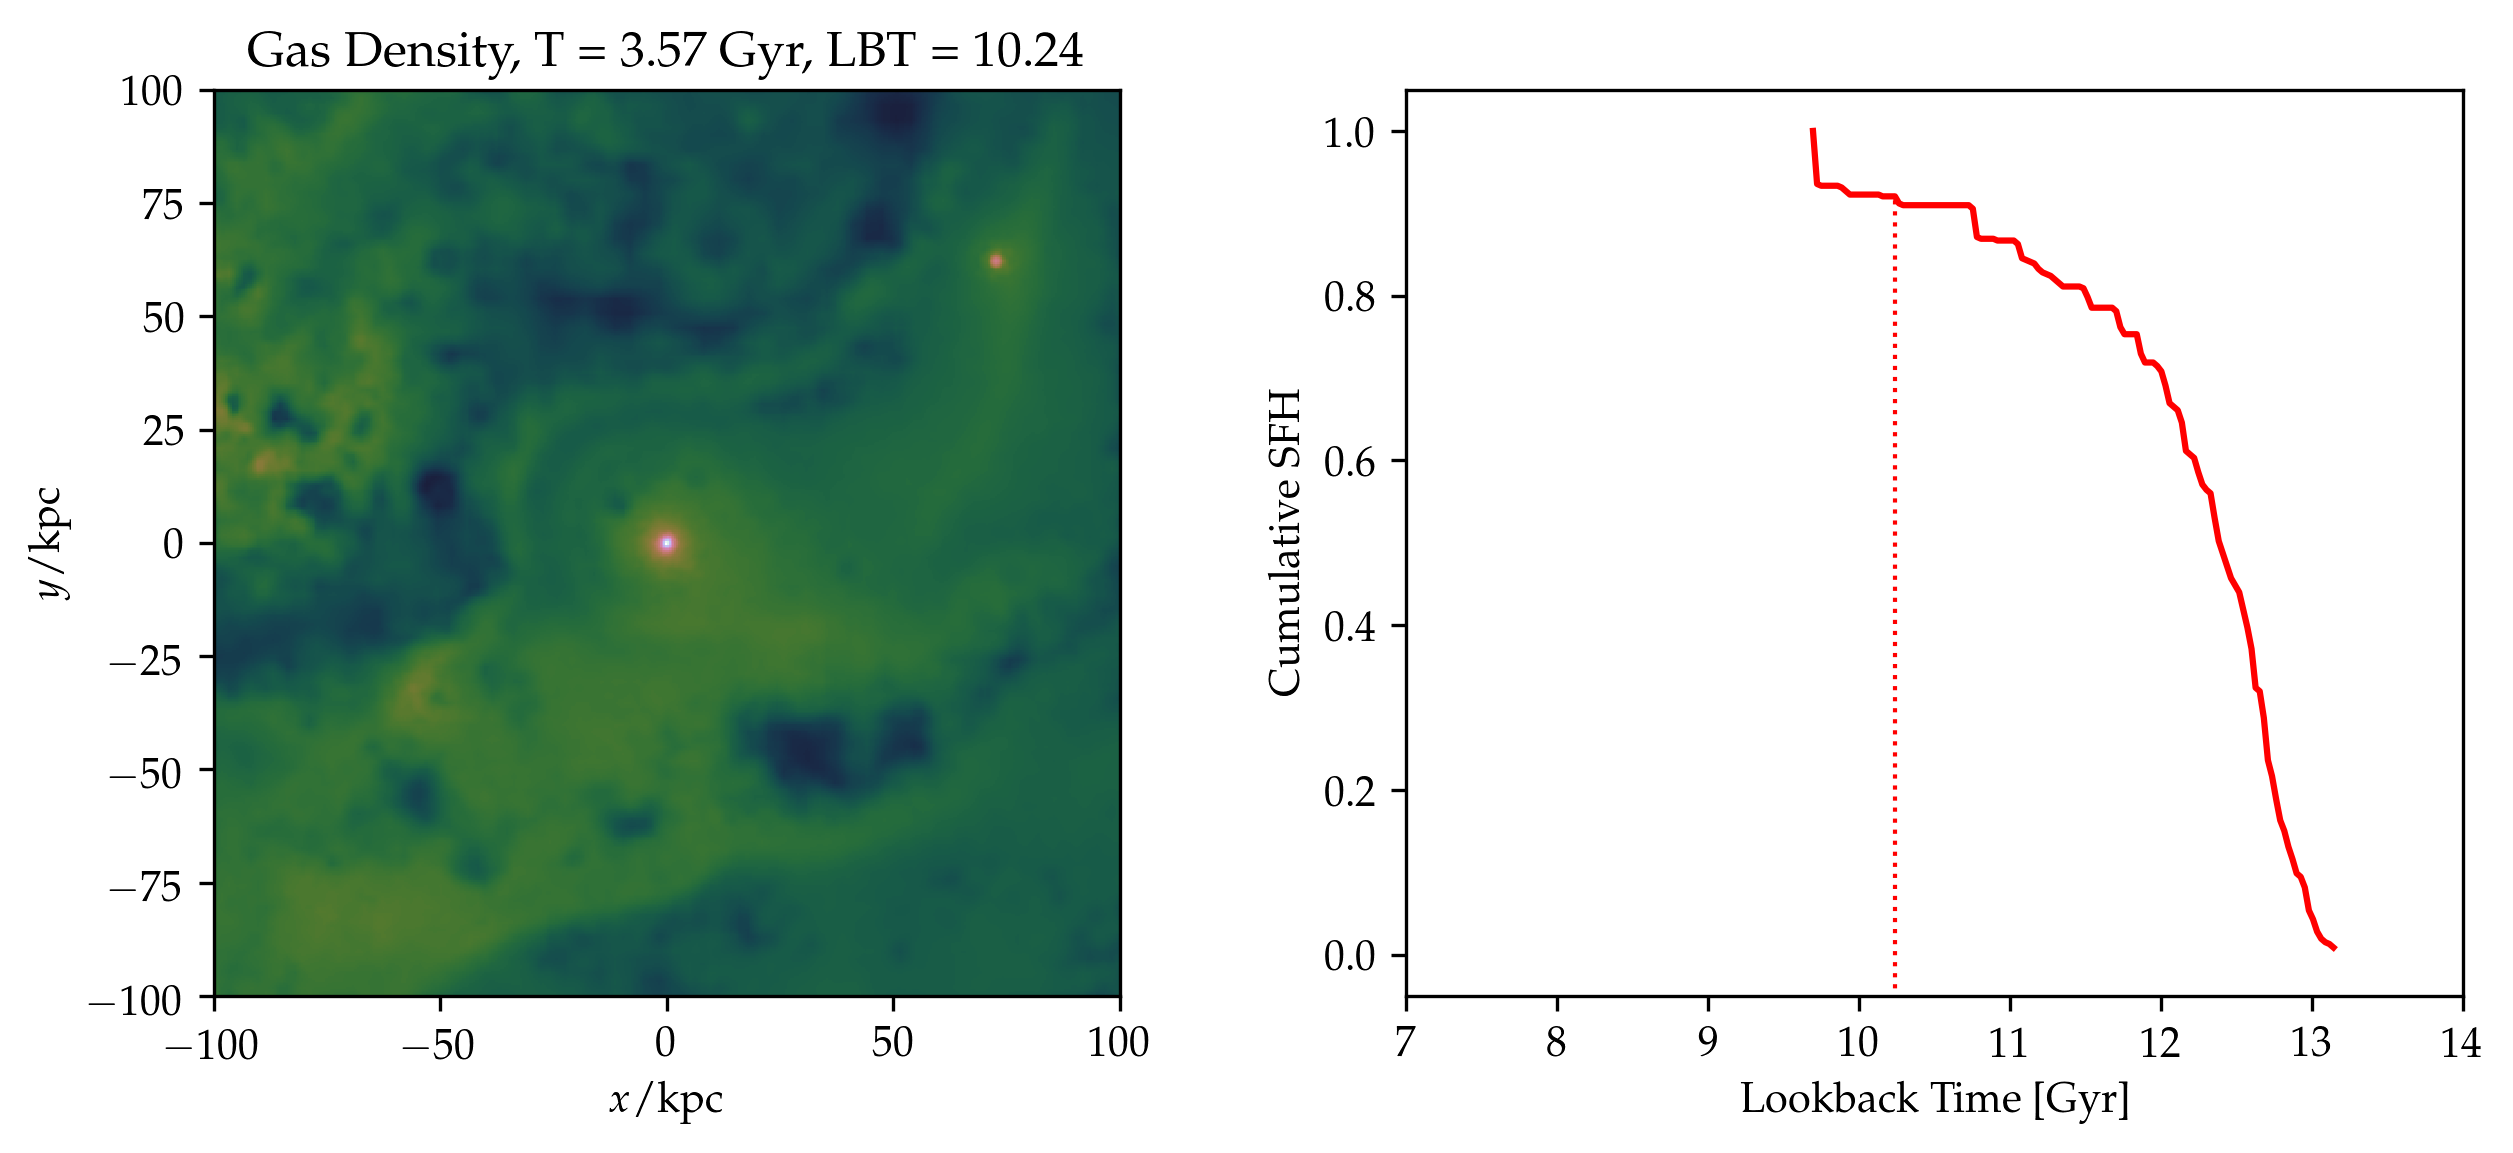

Snapshot h229.cosmo50PLK.3072gst5HbwK1BH.001106
Centering...
Generating Image..., width 200 kpc


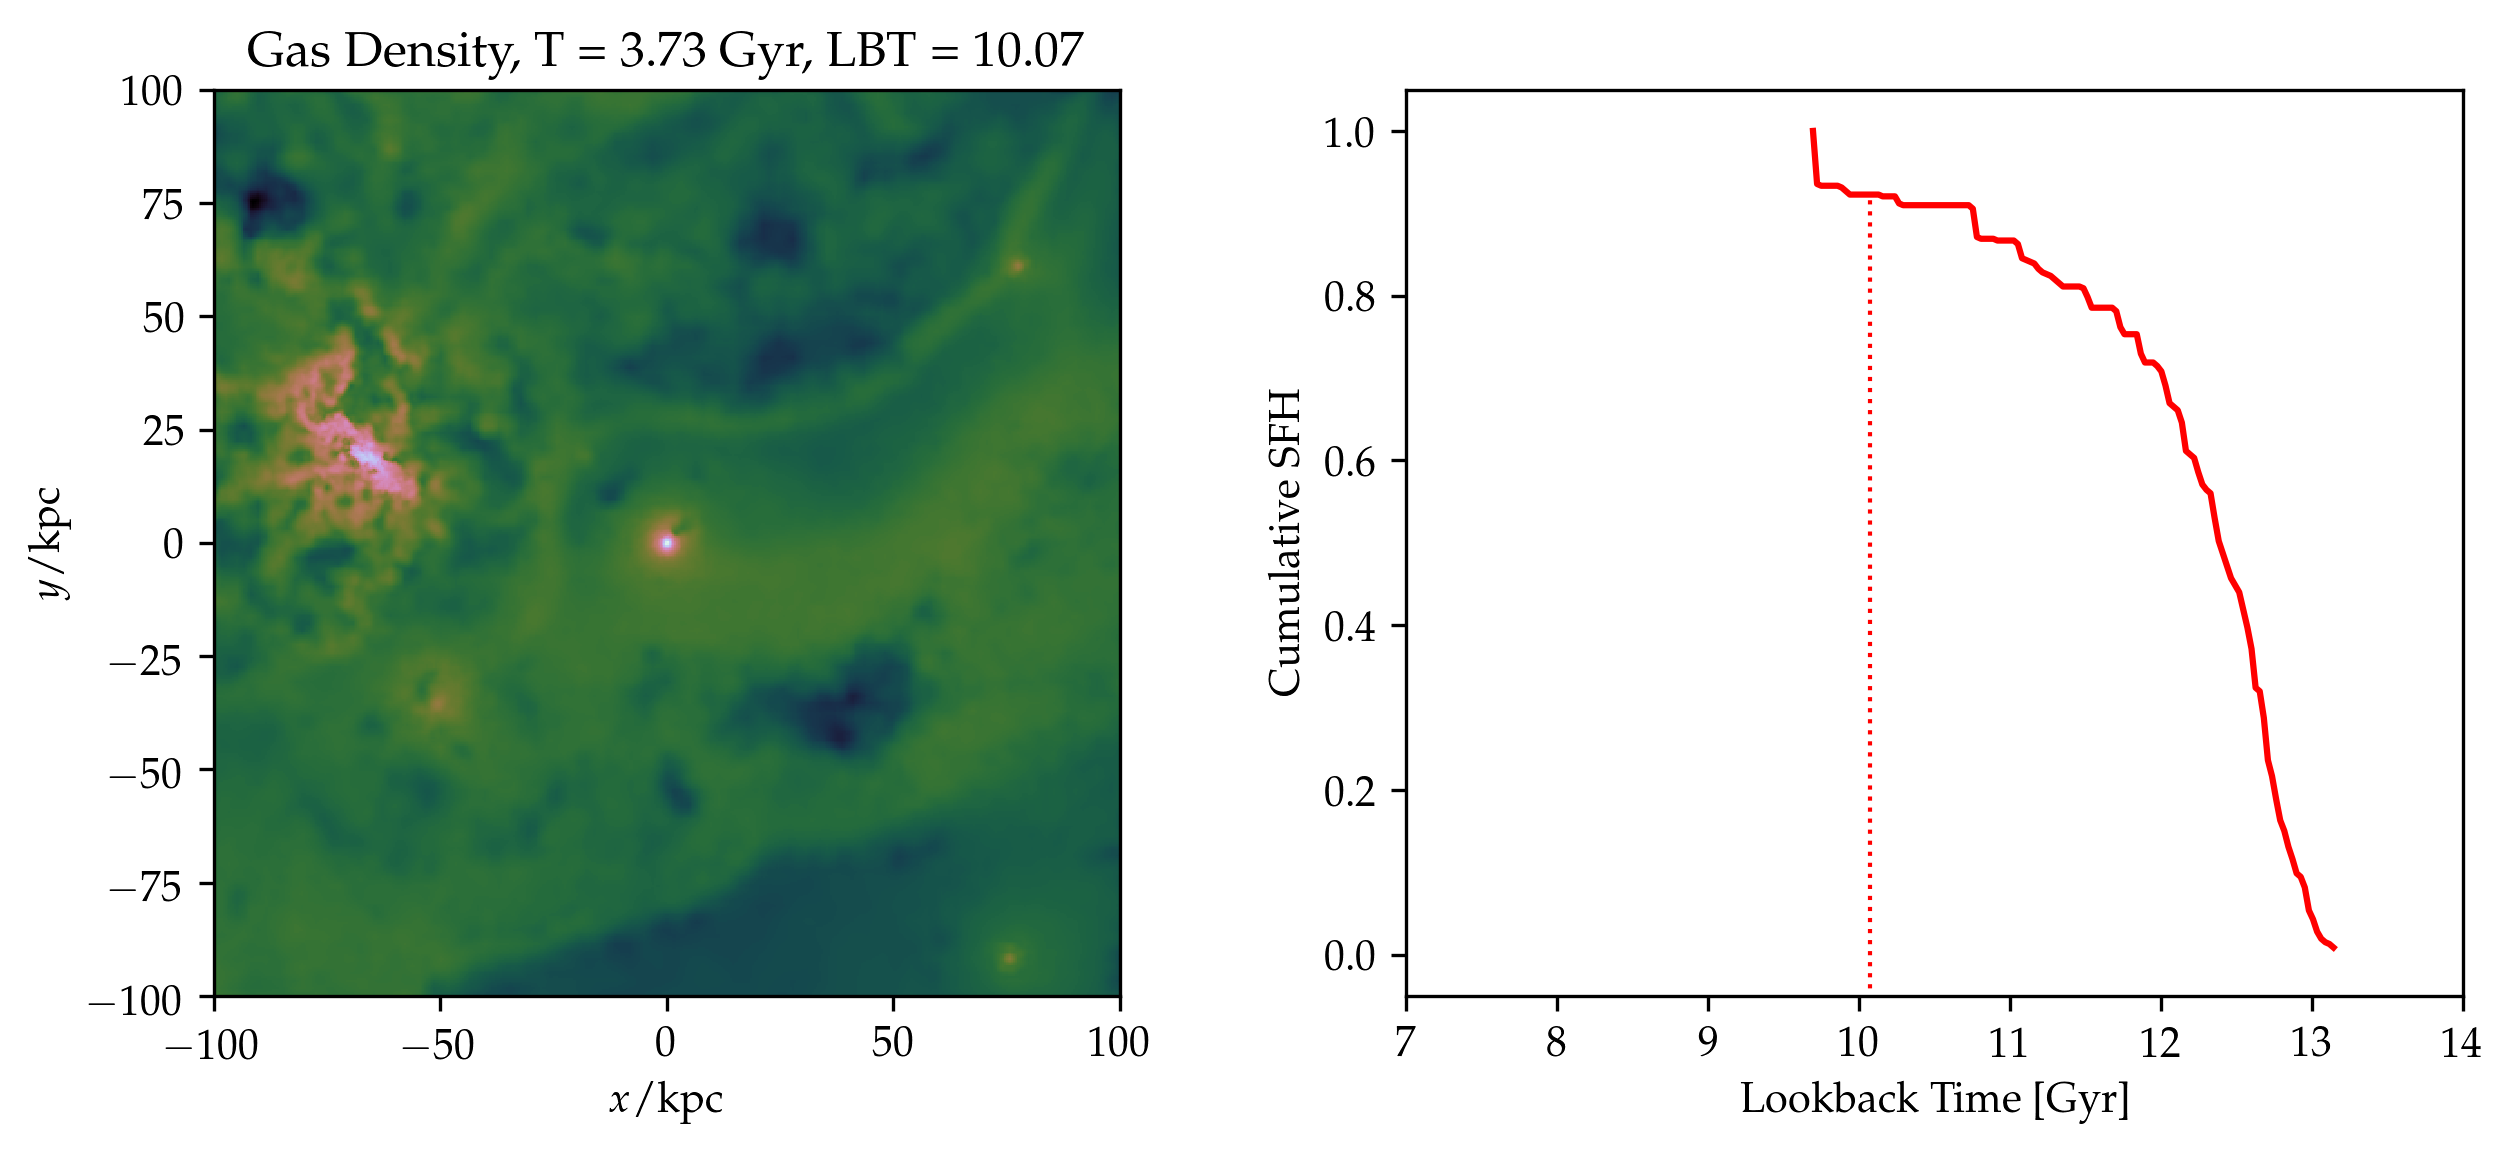

Snapshot h229.cosmo50PLK.3072gst5HbwK1BH.001152
Centering...
Generating Image..., width 200 kpc


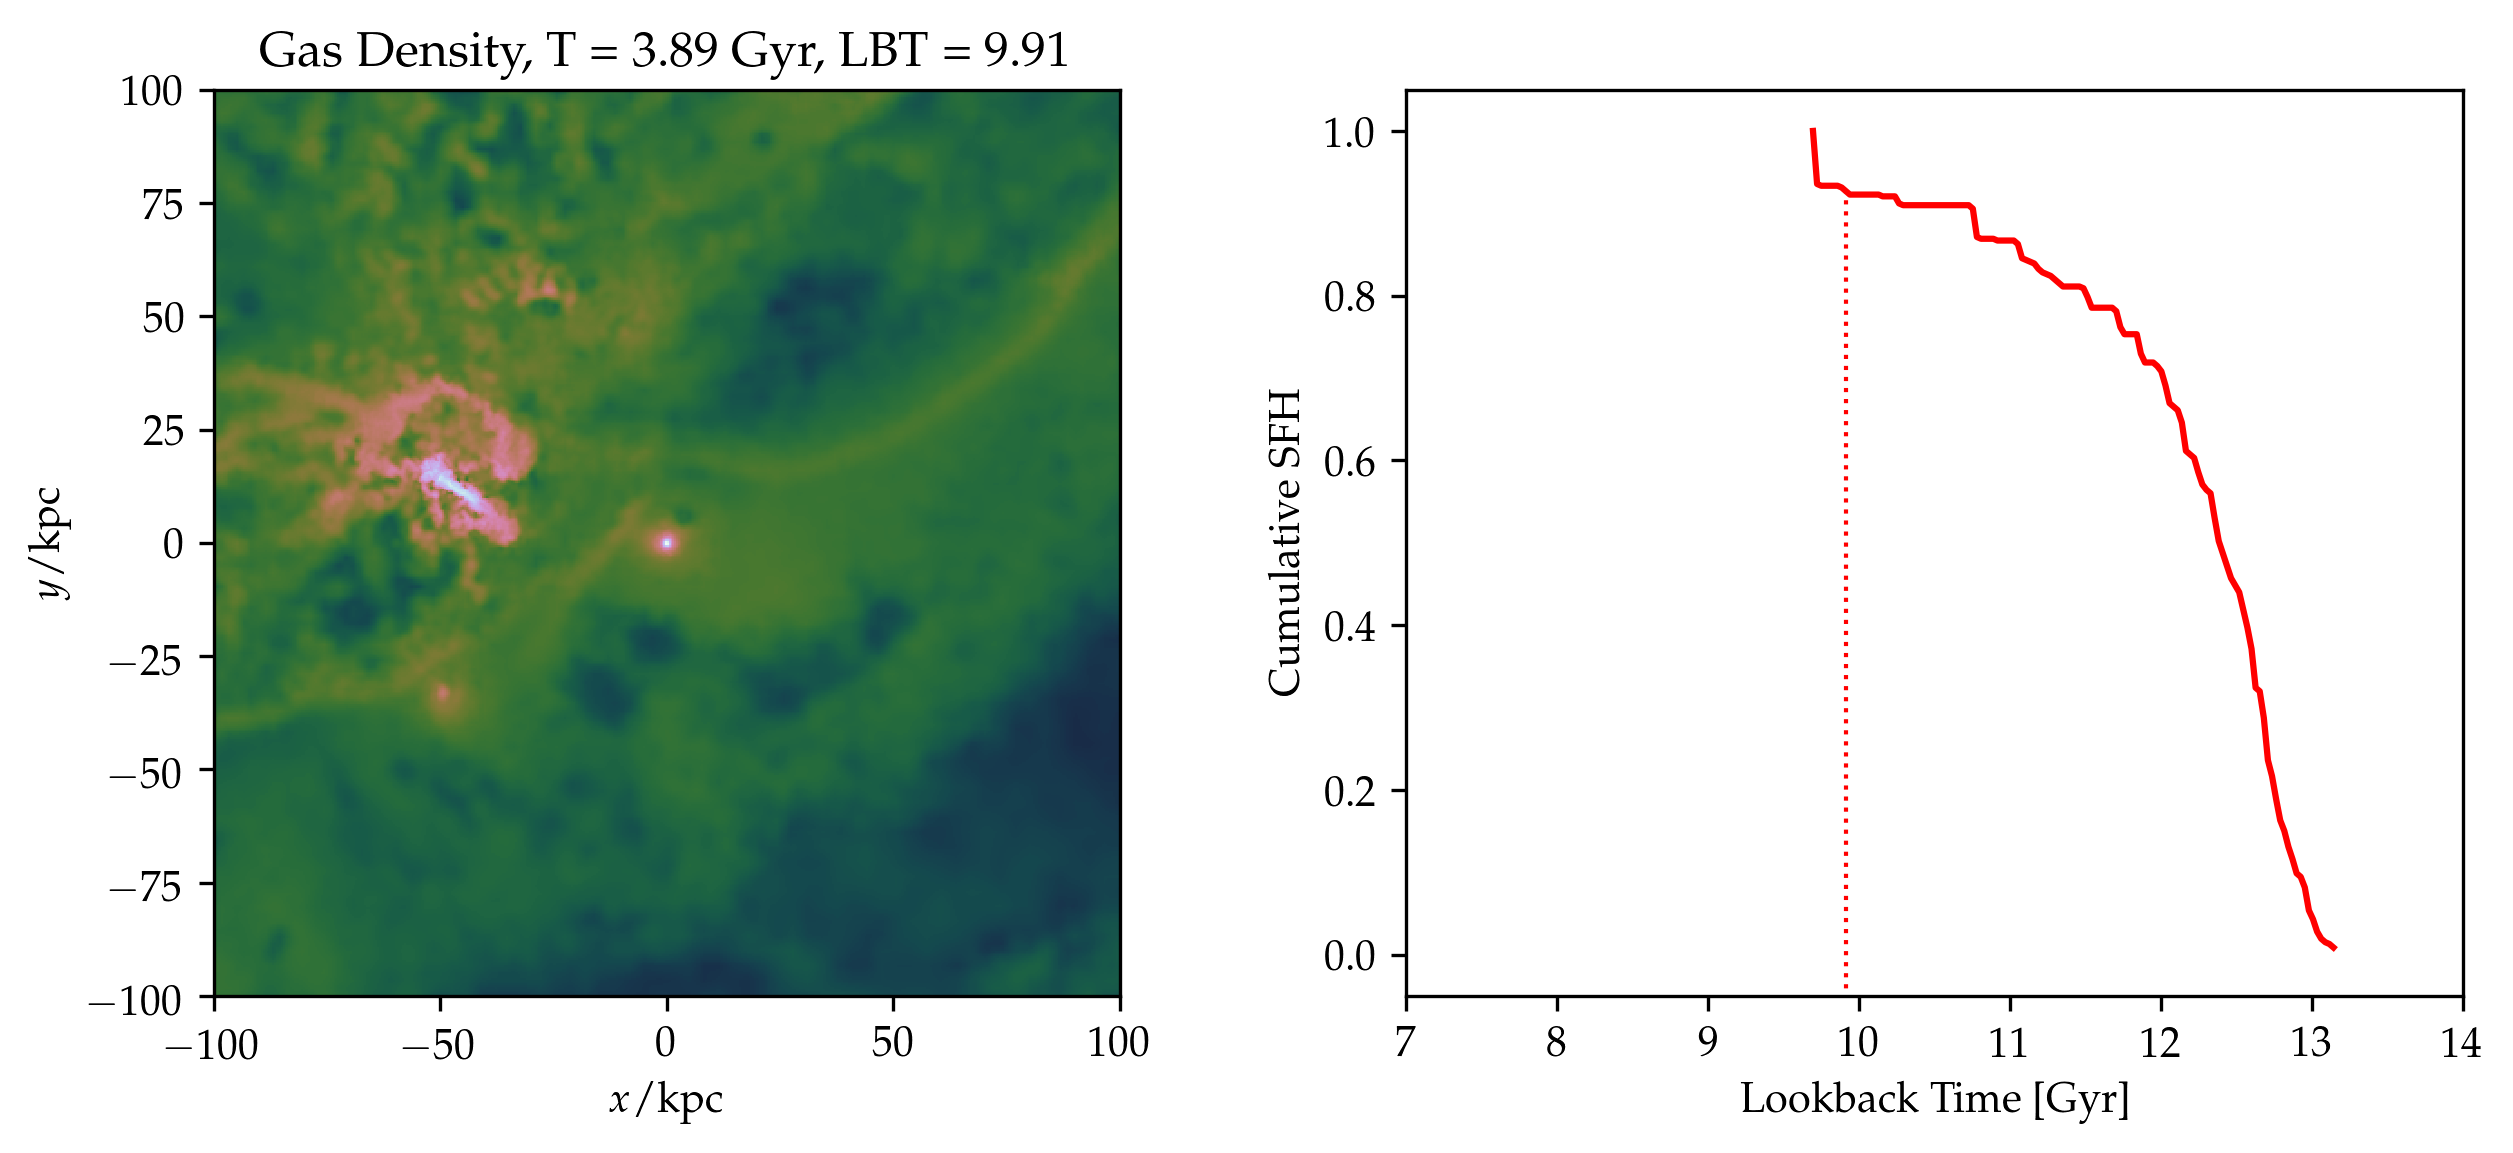

Snapshot h229.cosmo50PLK.3072gst5HbwK1BH.001248
Centering...
Generating Image..., width 200 kpc


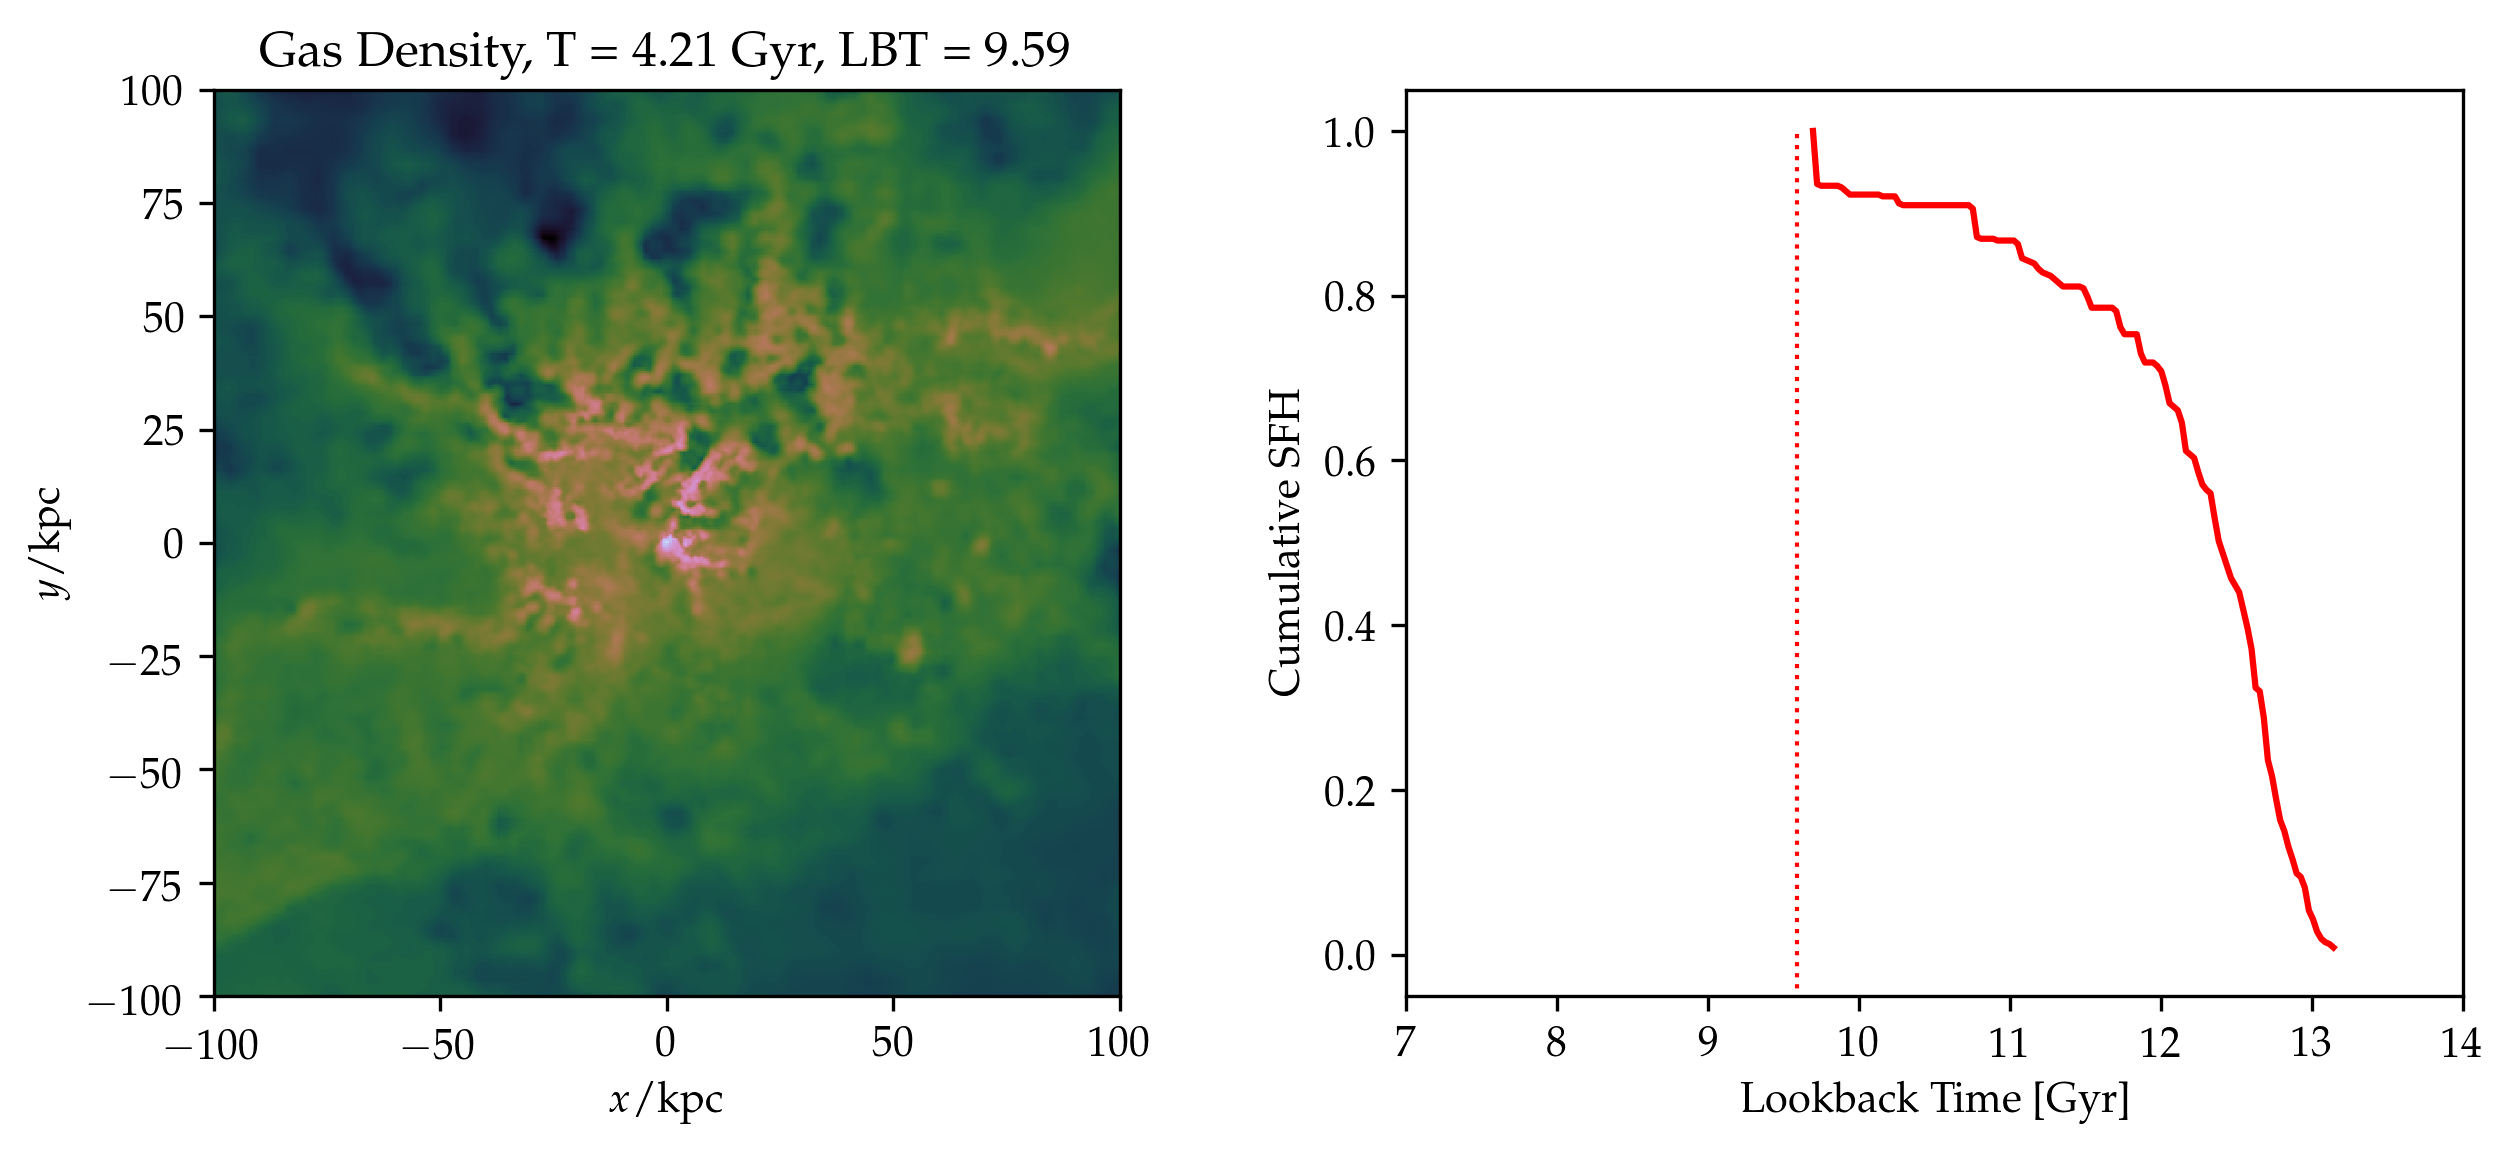

Snapshot h229.cosmo50PLK.3072gst5HbwK1BH.001269
Centering...
Generating Image..., width 200 kpc


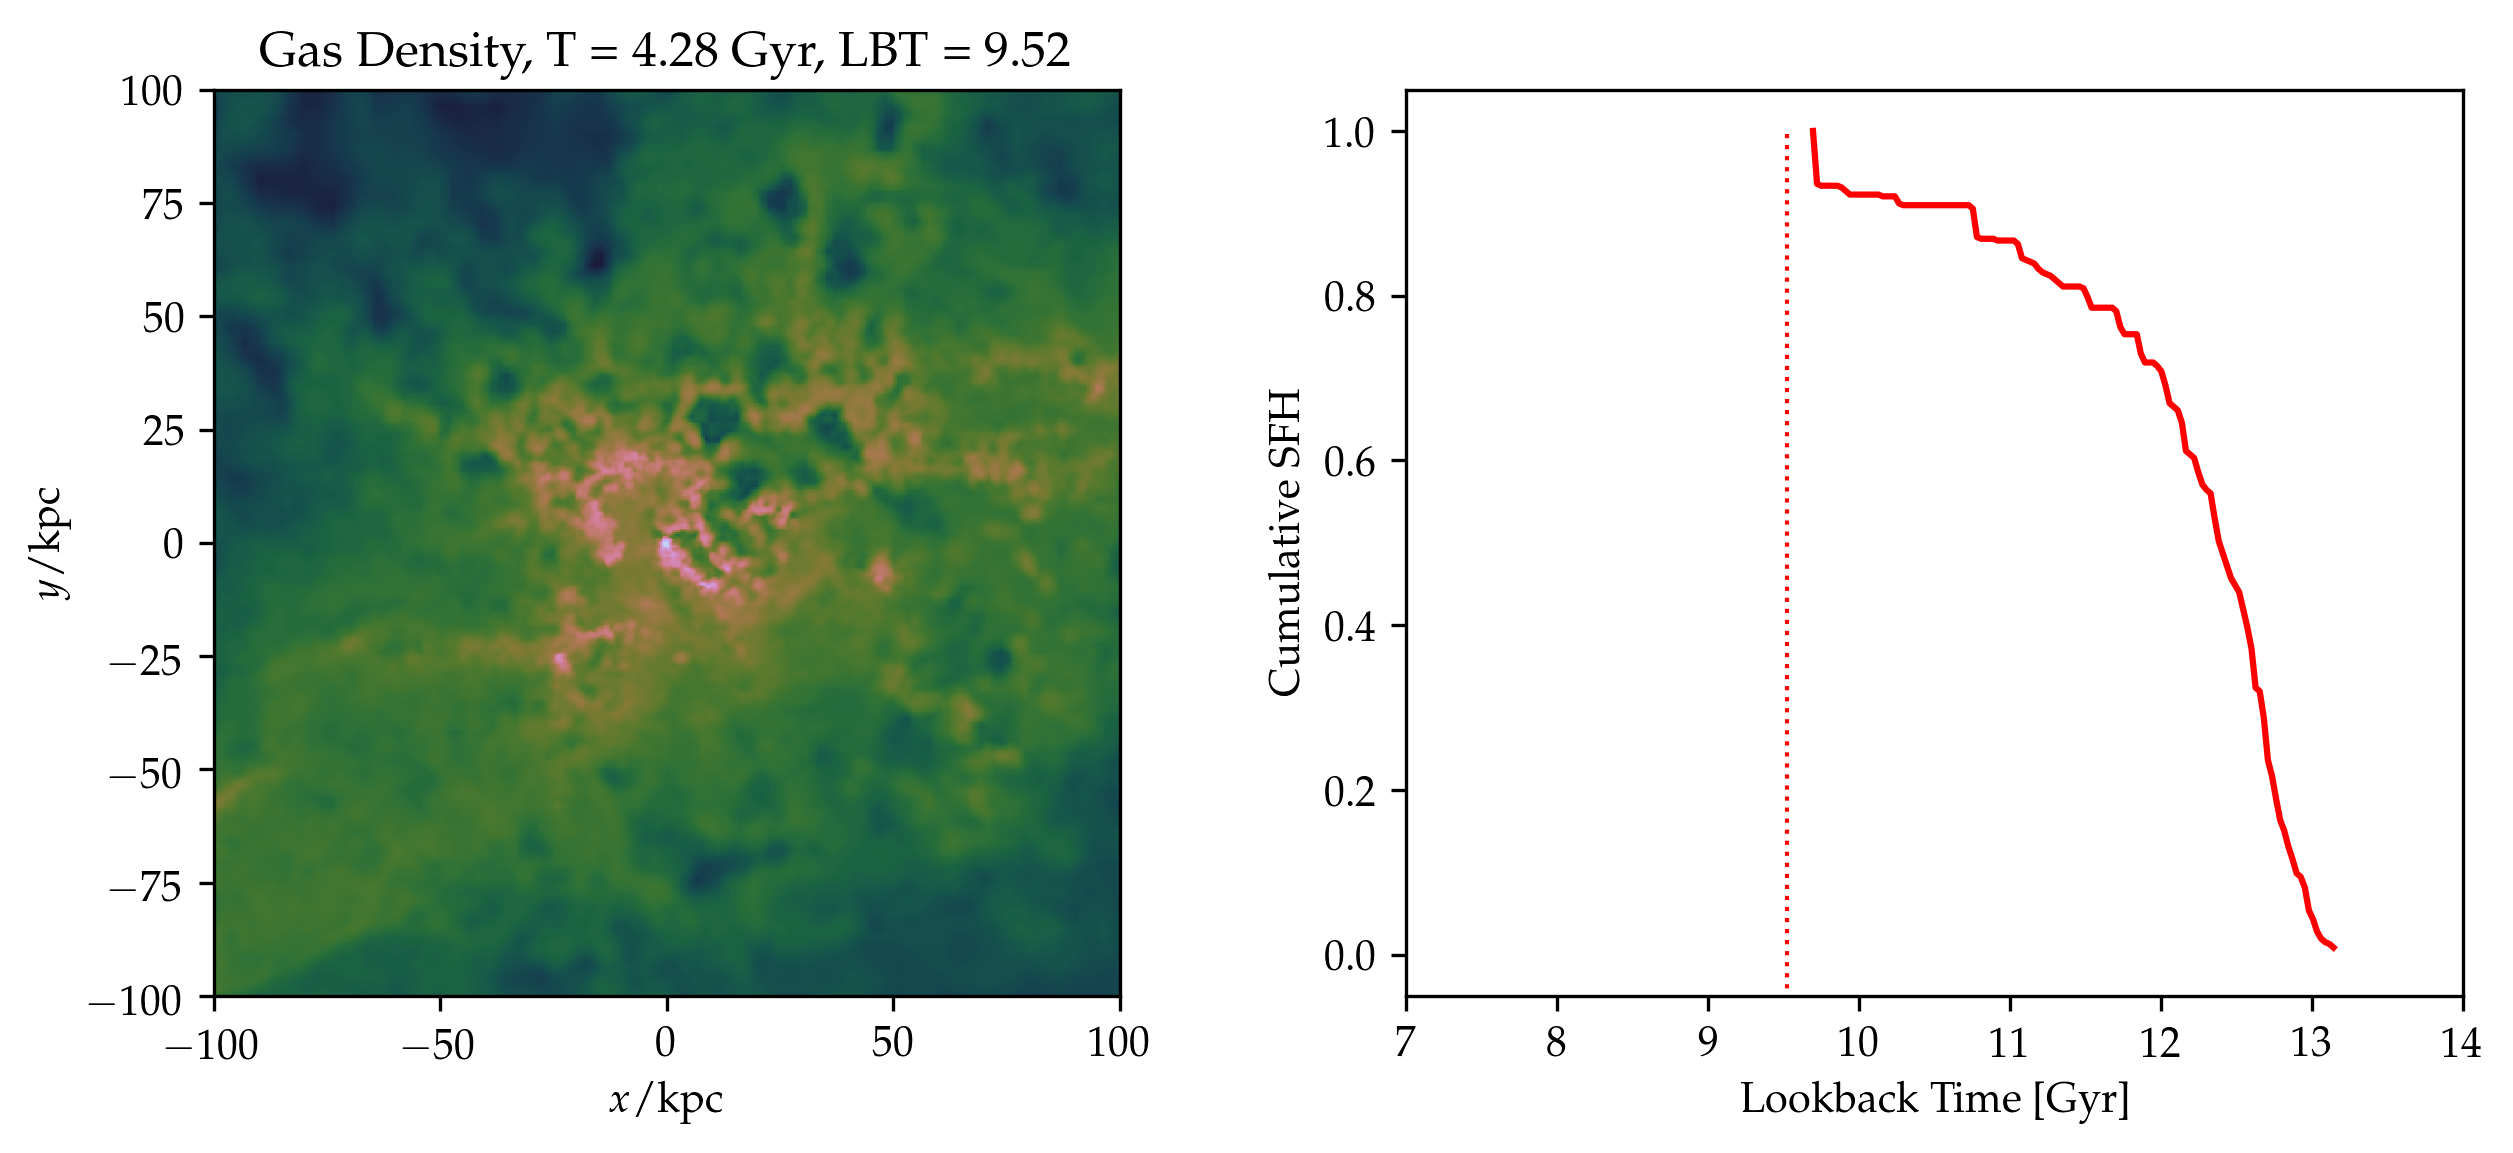

Snapshot h229.cosmo50PLK.3072gst5HbwK1BH.001344
Centering...
Generating Image..., width 200 kpc


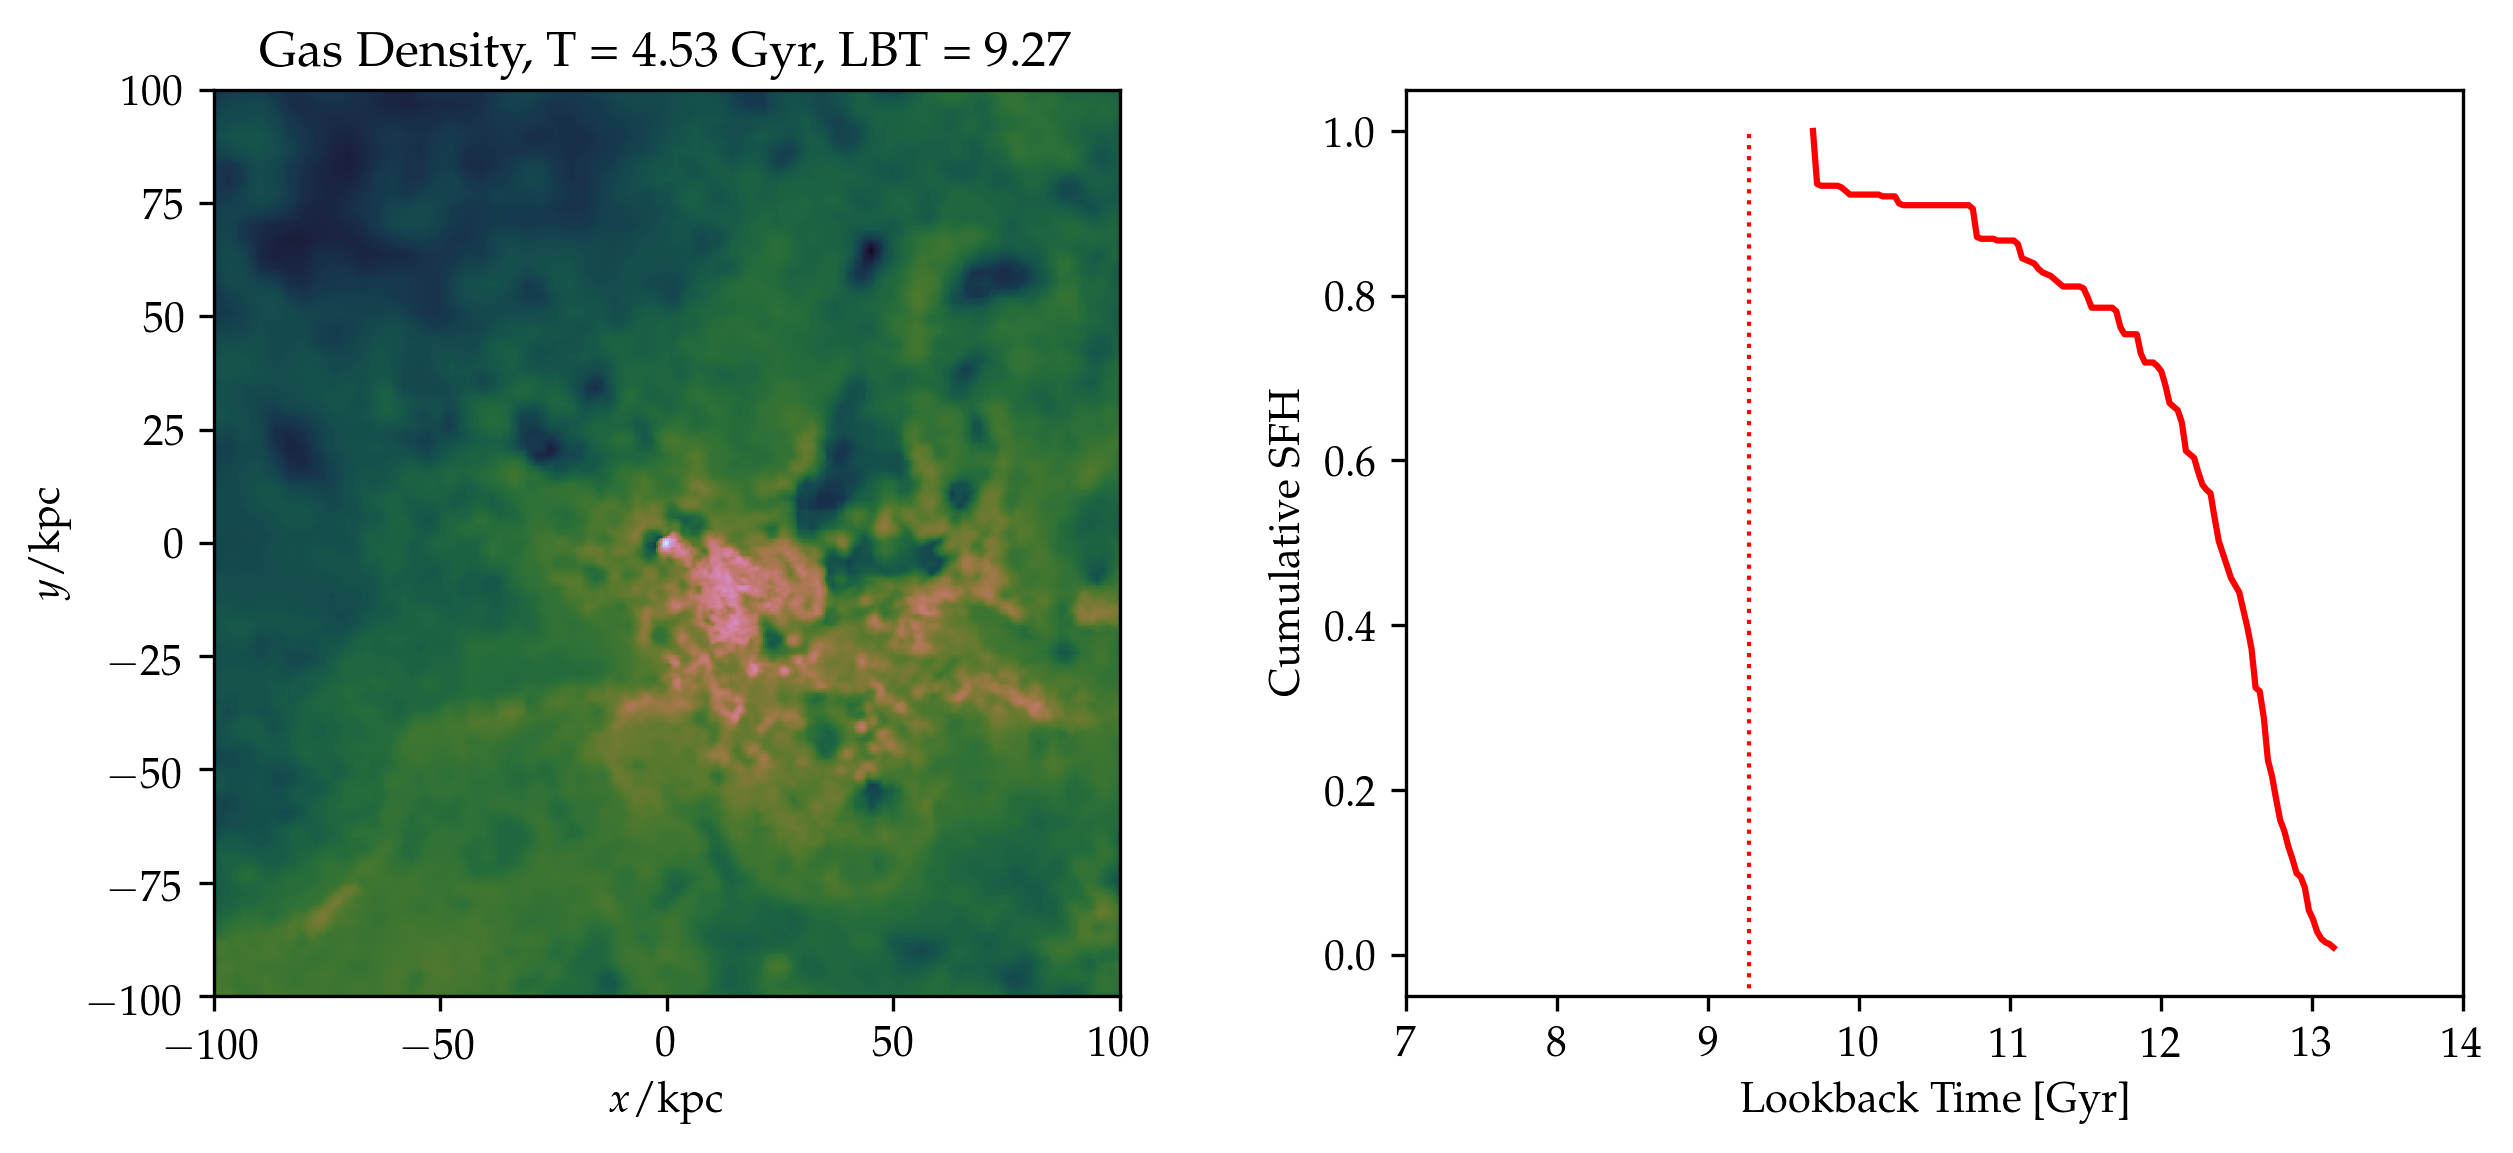

Snapshot h229.cosmo50PLK.3072gst5HbwK1BH.001440
Centering...
Generating Image..., width 200 kpc


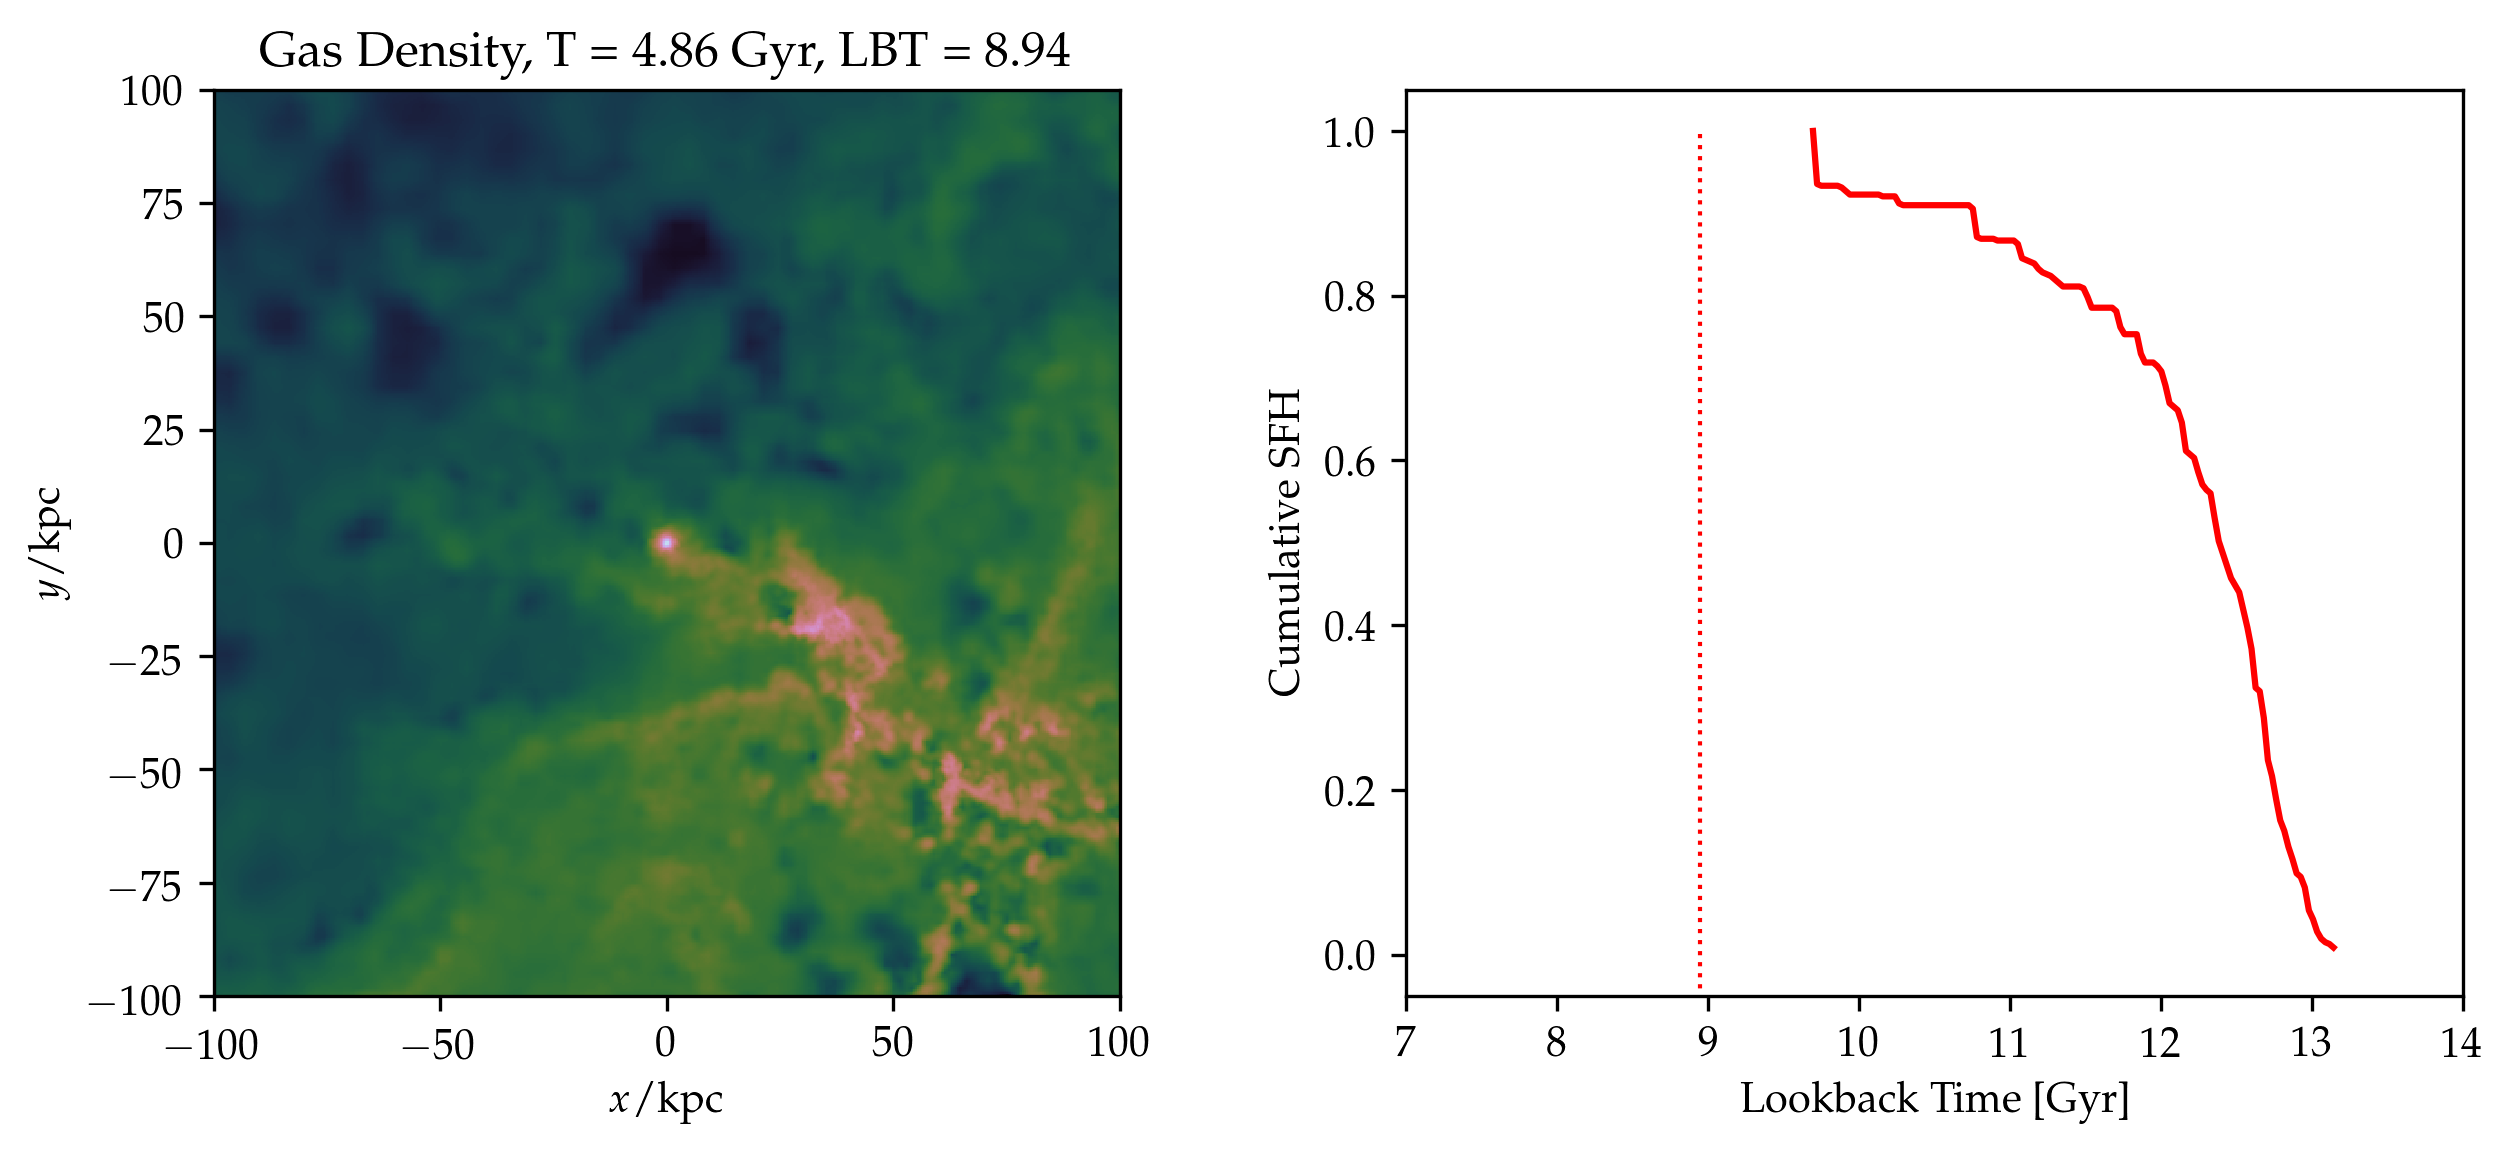

Snapshot h229.cosmo50PLK.3072gst5HbwK1BH.001475
Centering...
Generating Image..., width 200 kpc


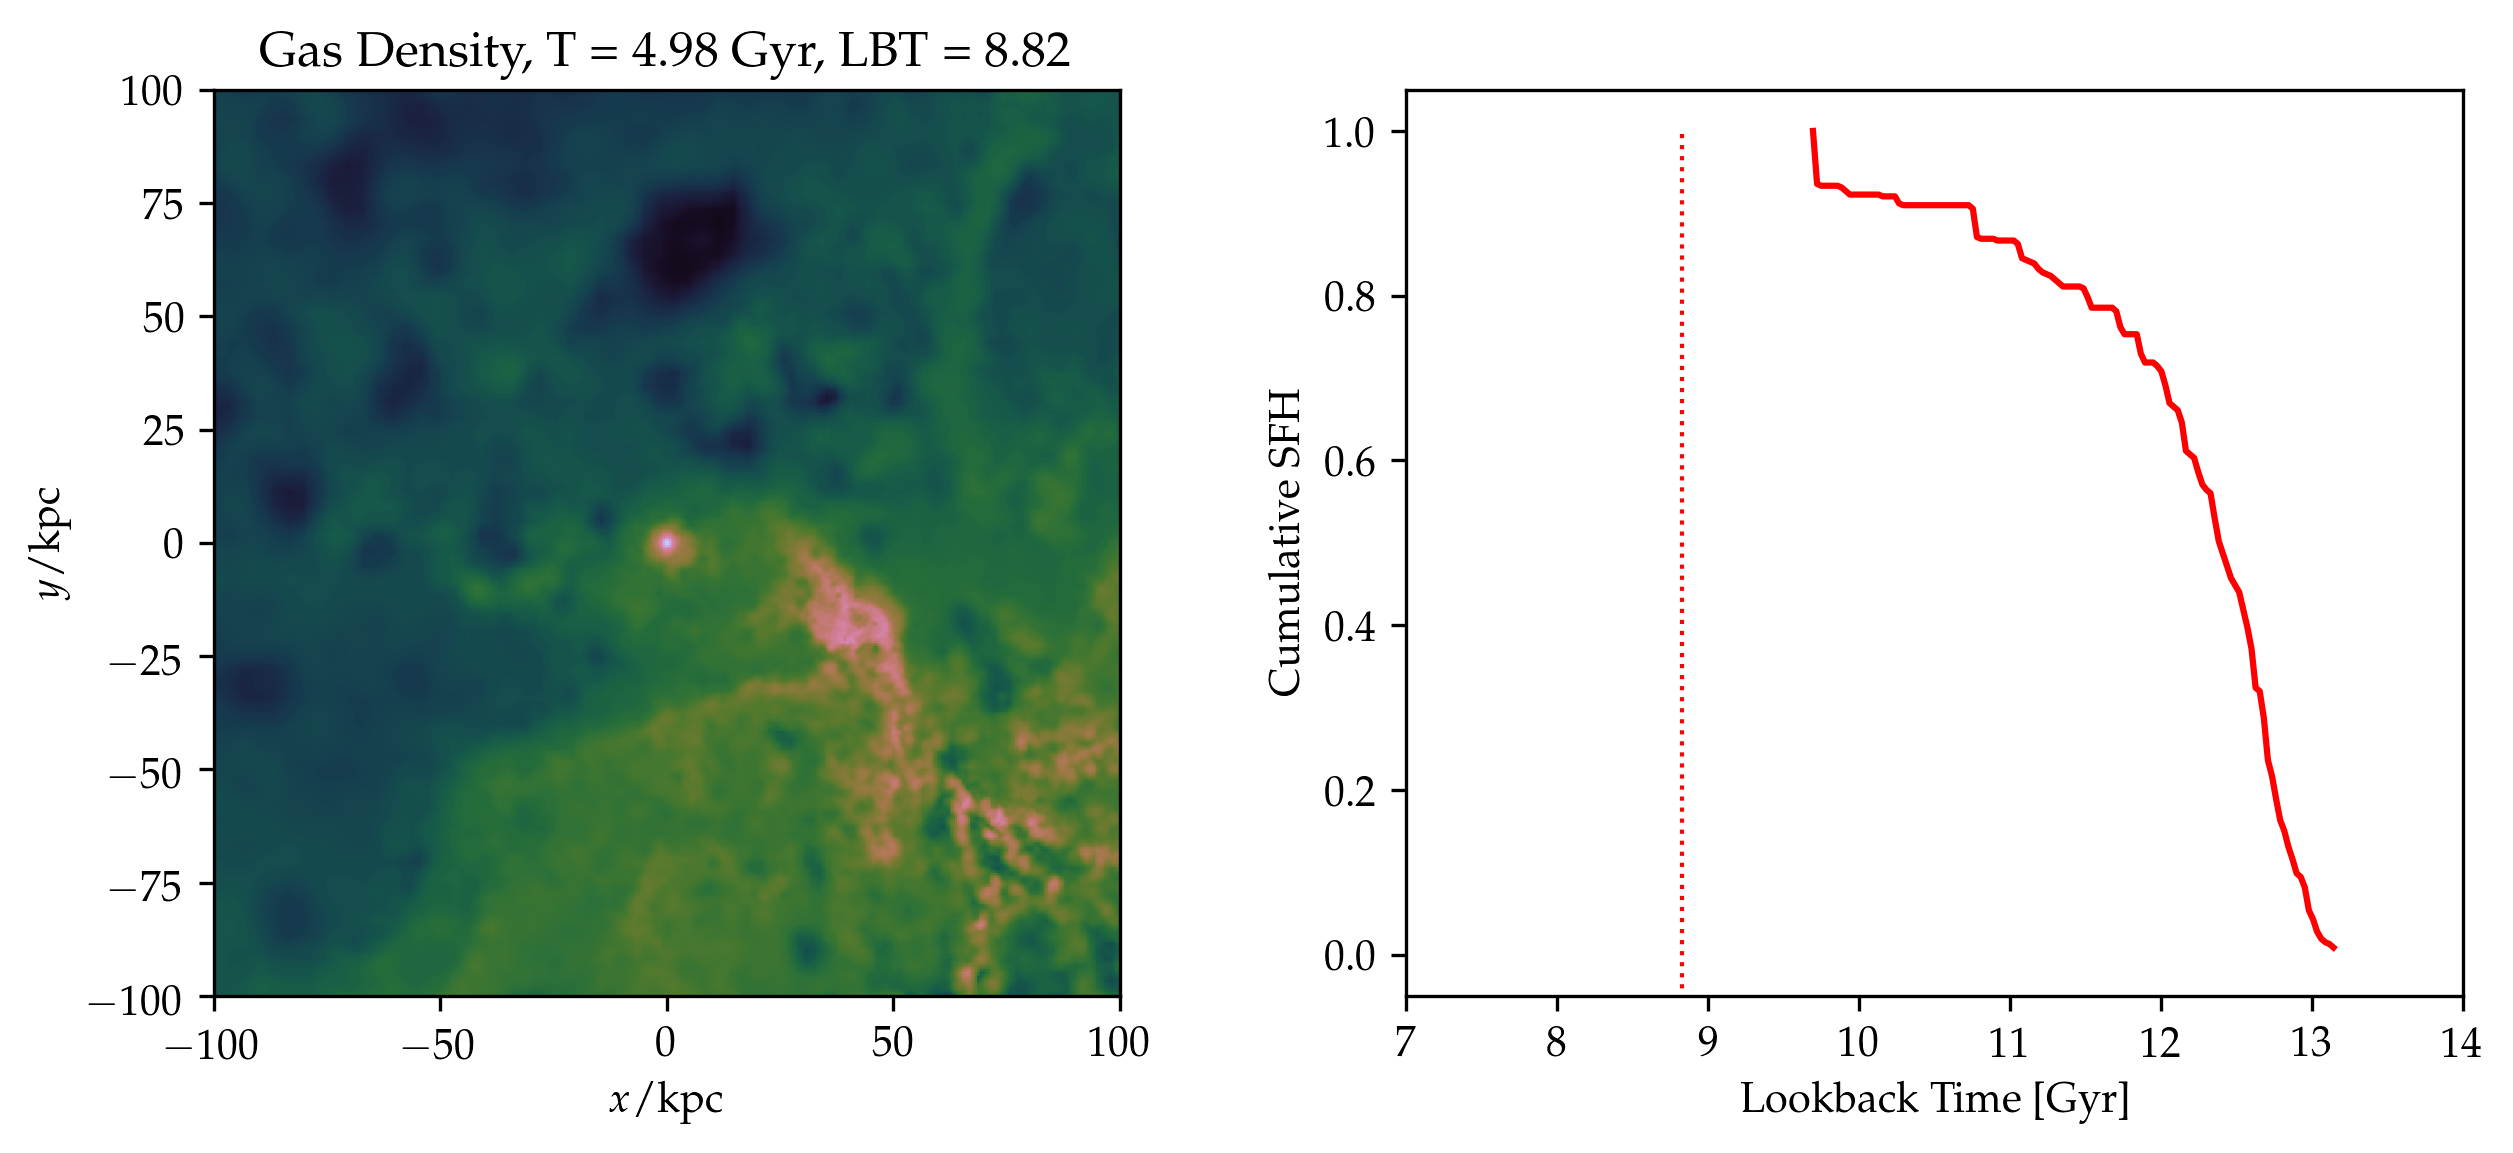

Snapshot h229.cosmo50PLK.3072gst5HbwK1BH.001536
Centering...
Generating Image..., width 200 kpc


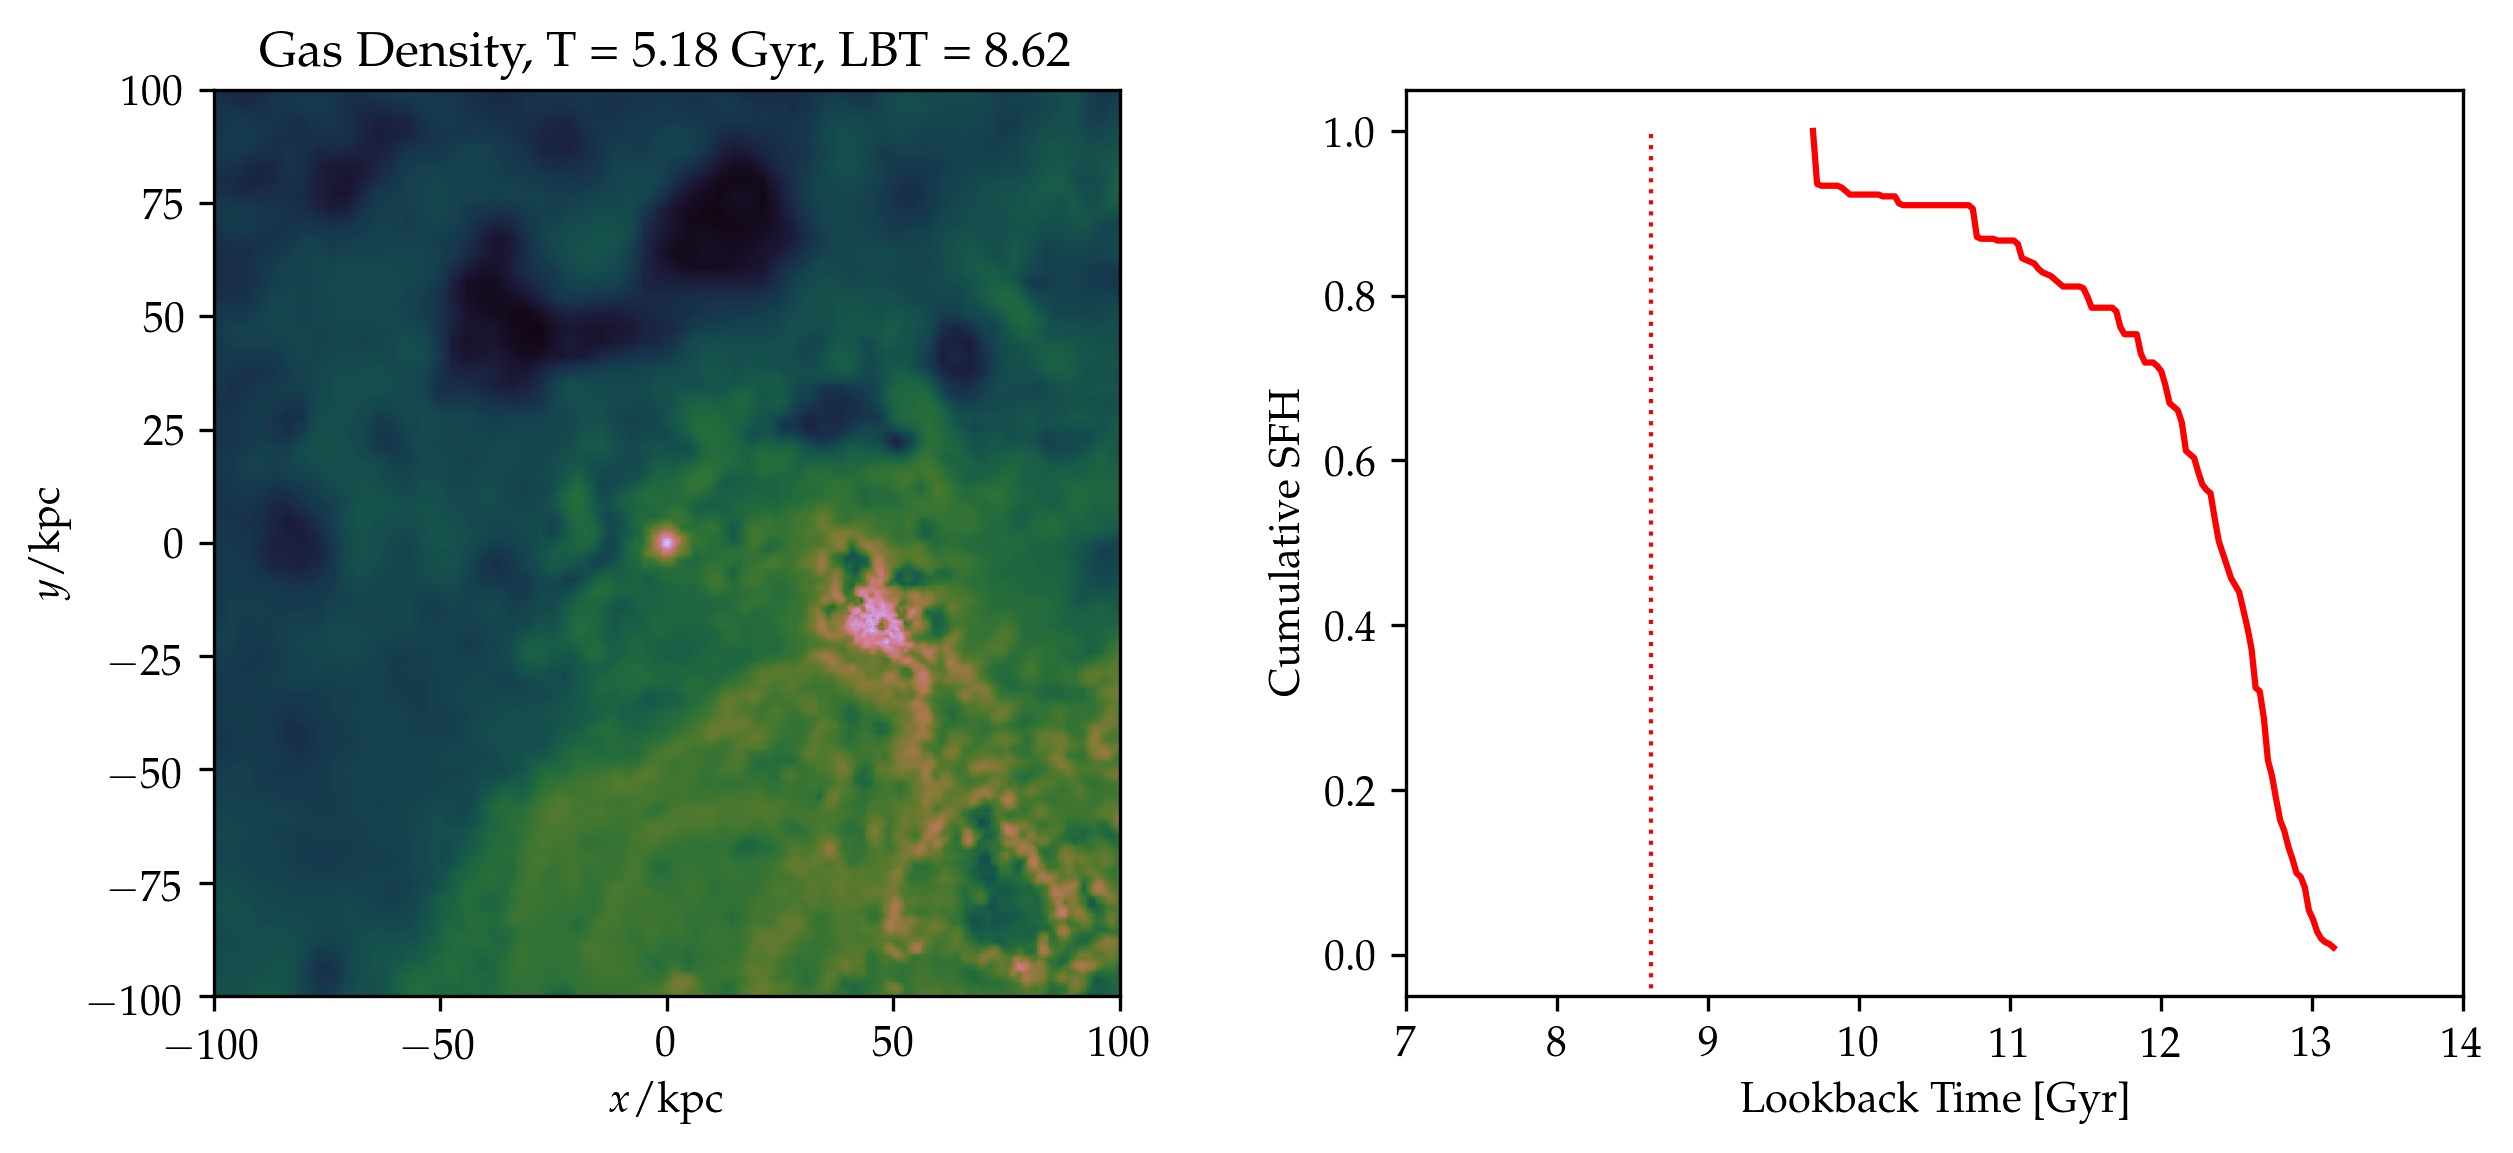

Snapshot h229.cosmo50PLK.3072gst5HbwK1BH.001632
Centering...
Generating Image..., width 200 kpc


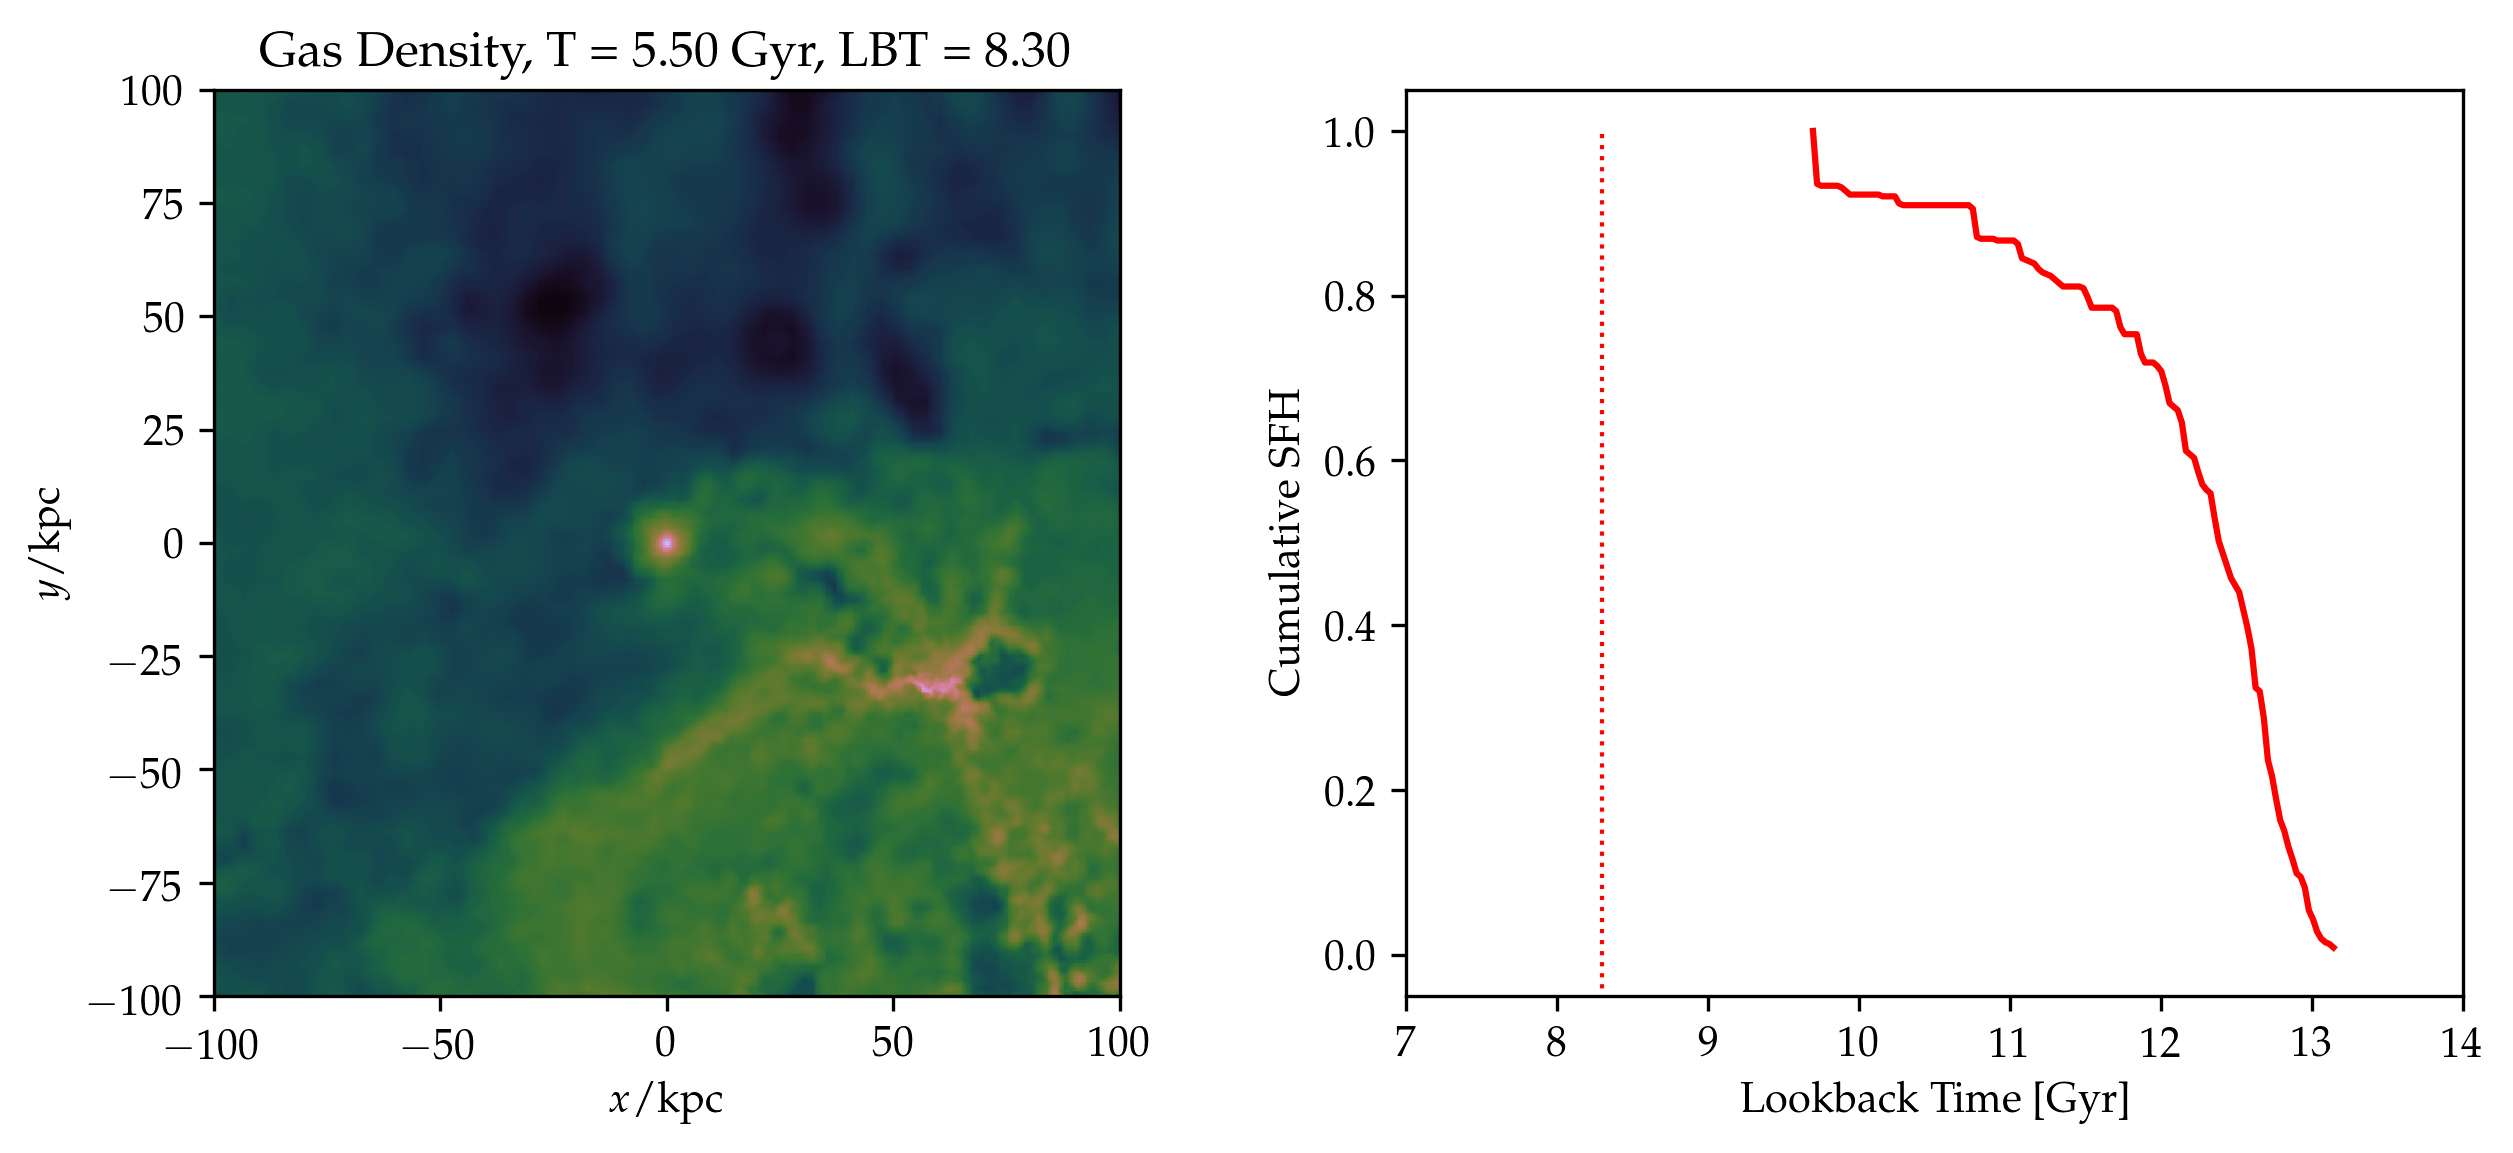

Snapshot h229.cosmo50PLK.3072gst5HbwK1BH.001728
Centering...
Generating Image..., width 200 kpc


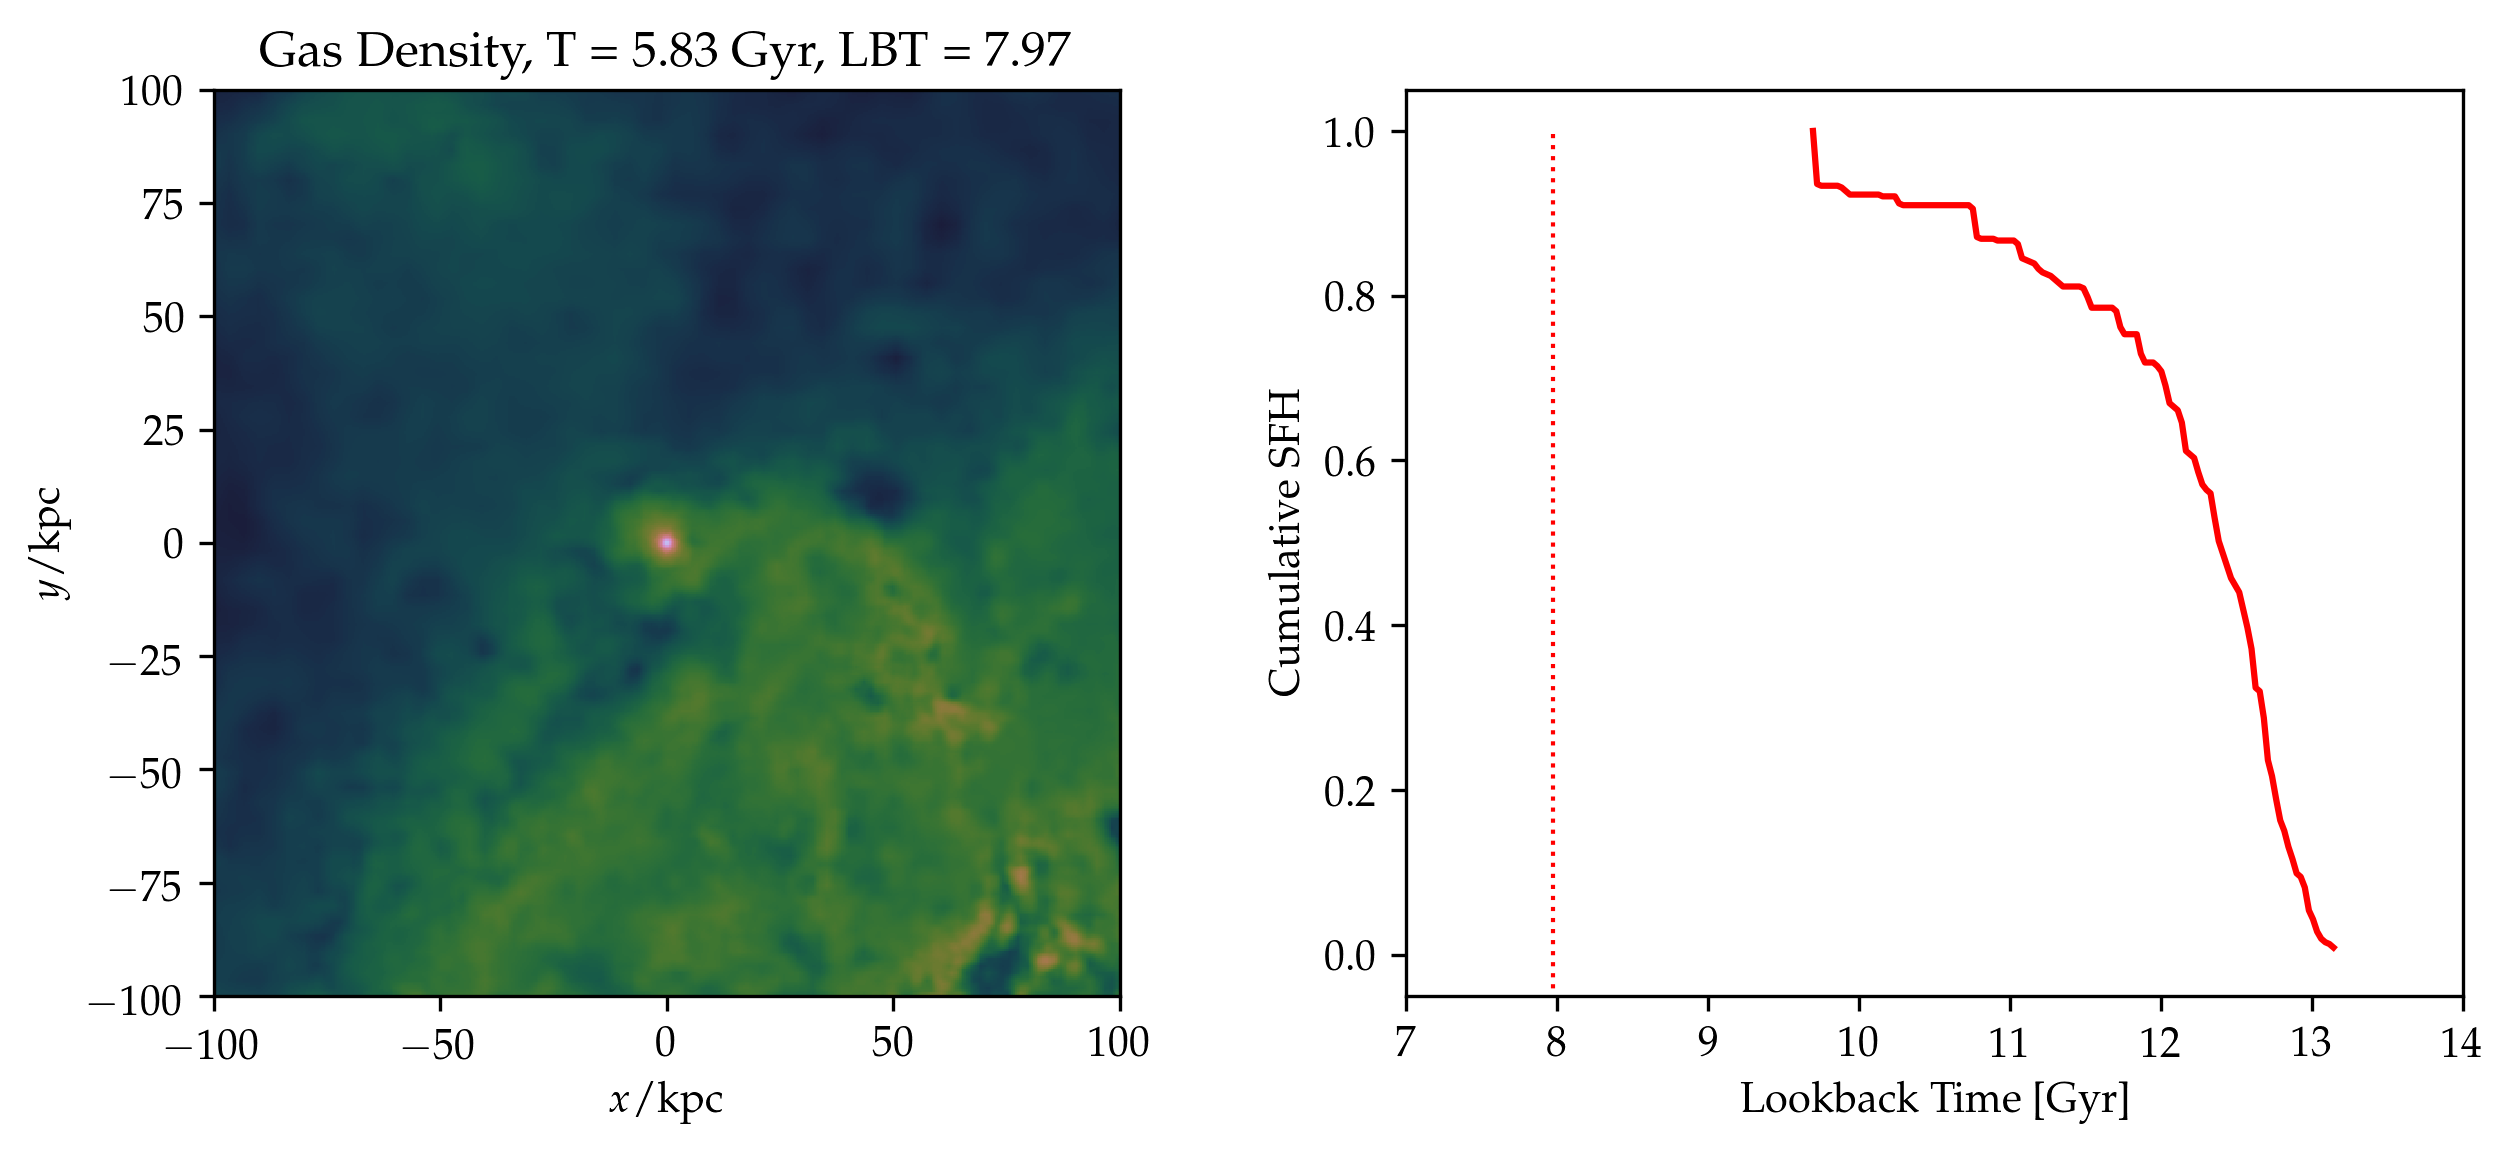

In [146]:
c_sfh, bc = cumulative_sfh(91)
haloids = [91, 88, 84, 82, 78, 73, 72, 74, 74, 73, 72, 70, 68, 61, 57, 55, 54, 50, 40, 38, 39, 39, 40, 40, 38, 37, 36, 38, 38, 33, 38, 37, 36, 33, 30, 32, 24, 33, 26, 27, 25, 31, 32, 29, 32, 32, 36, 37, 41, 44, 42, 39, 39, 37, 38, 59, 97, 99, 229]

for haloid, snapshot in zip(np.flip(haloids[30:45]),np.flip(snapshots[30:45])):
        print('Snapshot %s' % snapshot)
        s = pynbody.load('/home/christenc/Data/Sims/h229.cosmo50PLK.3072g/h229.cosmo50PLK.3072gst5HbwK1BH/snapshots/'+snapshot)
        s.physical_units()
        h = s.halos()
        halo = h[haloid]
        rvir = int(float(halo.properties['Rvir']))
        print('Centering...')
        pynbody.analysis.halo.center(halo)

        width = 200
        age = 13.800797497330507
        time = float(halo.properties['time'].in_units('Gyr'))

        %matplotlib inline
        fig, ax = plt.subplots(1,2,figsize=(10,4), dpi=300)
        print('Generating Image..., width %s kpc' % width)
        pynbody.plot.sph.image(s.g, cmap='cubehelix', width='%s kpc' % width, subplot = ax[0], vmin=1e1, vmax=1e8,show_cbar=False,title=f'Gas Density, T = {time:.2f} Gyr, LBT = {age-time:.2f}')
        
        try:
            c_sfh_current = np.min(c_sfh[bc < (age-time)])
        except:
            c_sfh_current = 1
        ax[1].plot(bc,c_sfh,'r-')
        ax[1].plot([age-time,age-time],[-1,c_sfh_current], 'r:', linewidth=1)
        ax[1].set_ylim(-0.05,1.05)
        ax[1].set_xlim(14,7)
        ax[1].set_xlabel('Lookback Time [Gyr]')
        ax[1].set_ylabel('Cumulative SFH')
        ax[1].invert_xaxis()

        plt.savefig('h229_91_Movie/%s.png' % snapshot, dpi=300)
        plt.show()



In [147]:
import imageio
import os

path = '/home/akinshol/Data/Timescales/h229_91_Movie/'

image_folder = os.fsencode(path)
filenames = []
for file in os.listdir(image_folder):
    filename = os.fsdecode(file)
    if filename.endswith('.png'):
        filenames.append(filename)
    
filenames.sort()
print(filenames)

images = list(map(lambda filename: imageio.imread(path+filename), filenames))

s = 30

imageio.mimsave('movie_h229_91.gif', images, duration = s/60)

['h229.cosmo50PLK.3072gst5HbwK1BH.000776.png', 'h229.cosmo50PLK.3072gst5HbwK1BH.000864.png', 'h229.cosmo50PLK.3072gst5HbwK1BH.000960.png', 'h229.cosmo50PLK.3072gst5HbwK1BH.000974.png', 'h229.cosmo50PLK.3072gst5HbwK1BH.001056.png', 'h229.cosmo50PLK.3072gst5HbwK1BH.001106.png', 'h229.cosmo50PLK.3072gst5HbwK1BH.001152.png', 'h229.cosmo50PLK.3072gst5HbwK1BH.001248.png', 'h229.cosmo50PLK.3072gst5HbwK1BH.001269.png', 'h229.cosmo50PLK.3072gst5HbwK1BH.001344.png', 'h229.cosmo50PLK.3072gst5HbwK1BH.001440.png', 'h229.cosmo50PLK.3072gst5HbwK1BH.001475.png', 'h229.cosmo50PLK.3072gst5HbwK1BH.001536.png', 'h229.cosmo50PLK.3072gst5HbwK1BH.001632.png', 'h229.cosmo50PLK.3072gst5HbwK1BH.001728.png']
